In [2]:
from cgitb import text
import requests
import re
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import random
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import graphics
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_absolute_error

# Web Scraping

#### Scraping list of links to player stat pages

In [176]:
player_directory = 'https://www.vlr.gg/stats/?event_group_id=all&event_id=all&region=all&country=all&min_rounds=50&min_rating=1550&agent=all&map_id=all&timespan=60d'
main_response = requests.get(player_directory)
main_page_html = main_response.text
directory = bs(main_page_html,features="lxml")
player_url = []
for link in directory.tbody.find_all('a', href=re.compile("\/player\/[\d]+\/+[a-zA-Z0-9]+")):
    player_url.append('https://www.vlr.gg'+link.get("href"))

#### Scraps for team rating

In [3]:
team_directory = 'https://www.vlr.gg/rankings/'
team_url = ['north-america','europe','brazil','asia-pacific','korea','china','japan','la-s','la-n','oceania','mena','gc']

team_ranking = {}
for x in team_url:
    team_response = requests.get(team_directory+x)
    team_html = team_response.text
    directory = bs(team_html,features='lxml')
    for teams in directory.find_all('div', class_="rank-item wf-card fc-flex"):
        team_ranking[teams.find('a')['data-sort-value'].strip()] = teams.find('div', class_="rank-item-rating")['data-sort-value']

team_ranking    

{'OpTic Gaming': '2400',
 'XSET': '2275',
 'FaZe Clan': '2016',
 'NRG Esports': '1909',
 'Cloud9': '1901',
 '100 Thieves': '1885',
 'Evil Geniuses': '1861',
 'Ghost Gaming': '1859',
 'Shopify Rebellion': '1856',
 'Dark Ratio': '1822',
 'The Guard': '1810',
 'Version1': '1801',
 'TSM': '1758',
 'Knights': '1752',
 'City Boys': '1734',
 'Oxygen Academy': '1710',
 'Sentinels': '1706',
 'Soniqs': '1687',
 'TSM Academy': '1675',
 'Lenny Time': '1657',
 'Cosmic Divide': '1632',
 'Nearest Airport': '1631',
 'Knights Academy': '1630',
 'Built By Gamers Academy': '1628',
 'The Ganaccis': '1627',
 'T1': '1601',
 'VIRTUOSO': '1595',
 'DNADIFF': '1577',
 'SHIFT': '1554',
 'Team Basilisk': '1551',
 'Elysium': '1536',
 'Zero MarksMen Black': '1534',
 'Teal Seam': '1532',
 'Team Reckaroo': '1527',
 'Surf Esports': '1500',
 'Maidenless': '1494',
 'CrouchShoot': '1485',
 'Flex Gaming': '1482',
 'Project VII': '1471',
 'TradeLikePros': '1399',
 'Vexo Esports': '1462',
 'QoR': '1456',
 'Lycus Empire': '1

#### Function to crawl through rows on player page

In [4]:
def player_page(soup):
    """
    specific for vlr.gg. Creates nested list for player's per agent stats/nested list
    """
    parsed_stats = []
    run_count = 0
    limit_count = 15
    for tag in range(len(soup.tbody.findAll("tr"))):
        parsed_stats.append(player_stats(soup,run_count,limit_count))
        limit_count += 15
        run_count += 1
    return(parsed_stats)

In [5]:
#function to pull stats of perforance of player on an agent
def player_stats (soup,run_count,limit_count):
    """
    Creates list of stats for player on one agent.
    List  in order of Current Team, Player (in game) Name, Agent Played, Role of the agent (as defined by the game developer), usage %, number of rounds played on agent,
    average combat score, kill/death ratio, average damage per round, kills assist death trade %, average kills per round , average assists per round,average first kills per round,
    average first deaths per round, kills, deaths, assists, first kills, first deaths, current team elo rating
    """
    if "Current Teams" in str(soup.find_all('h2', class_= 'wf-label mod-large')): 
        try:
            current_team = re.sub('\s\s+[\s\S\w\W\d\D]+','',soup.find('a', class_= 'wf-module-item mod-first').contents[-2].text.strip())
        except:
            current_team = 'n/a'
    else:
        current_team = "n/a"
    if current_team in team_ranking:
        team_rank = team_ranking.get(current_team)
    else:
        team_rank = 'n/a'
    player_name = str((soup.head.title.string).strip()).split(':',1)[0]
    agent_roles = {'phoenix':'duelist','jett':'duelist','reyna':'duelist','raze':'duelist','yoru':'duelist','neon':'duelist',
                   'brimstone':'controller','viper':'controller','omen':'controller','astra':'controller',
                   'sova':'initiator','breach':'initiator','skye':'initiator','kayo':'initiator','fade':'initiator',
                   'killjoy':'sentinel','cypher':'sentinel','sage':'sentinel','chamber':'sentinel'}
    agent_played = str(re.findall(r"\"(.*?)\"",str(soup.tbody.find_all("img")[run_count]))[0])
    role_on_team = agent_roles[agent_played]
    stats = [x.get_text(strip=True) for x in soup.find_all("td", class_="mod-right")[limit_count-15:limit_count]]
    usage = float(re.sub("\(\d*\)\s",'',stats[0]).strip('%'))/100
    rnd_num = stats[1]
    avg_combat_score = stats[2]
    kill_death_ratio = stats[3]
    avg_dmg = stats[4]
    kast = float(stats[5].strip('%'))/100
    kills_per_rnd = stats[6]
    ast_per_rnd = stats[7]
    fk_per_rnd = stats[8]
    fd_per_rnd = stats[9]
    kills = stats[10]
    death = stats[11]
    ast = stats[12]
    fk = stats[13]
    fd = stats[14]
    return [current_team,player_name,agent_played,role_on_team,usage,rnd_num,avg_combat_score,kill_death_ratio,avg_dmg,
            kast,kills_per_rnd,ast_per_rnd,fk_per_rnd,fd_per_rnd,kills,death,ast,fk,fd,team_rank]

#### Joins functions to run through vlr.gg and create Pandas DataFrame

In [180]:
#runs functions to create pd dataframe
val_df = pd.DataFrame(columns = ["current_team","player_name","agent_played","role_on_team","usage","rnd_num",
                                 "avg_combat_score","kill_death_ratio","avg_dmg","kast","kills_per_rnd","ast_per_rnd",
                                 "fk_per_rnd","fd_per_rnd","kills","death","ast","fk","fd","team_rank"])
for x in player_url:
    response = requests.get(x)
    page_html = response.text
    soup = bs(page_html,features='lxml')
    stats_list = []
    stats_list += player_page(soup)
    val_df = pd.concat([val_df,pd.DataFrame(stats_list,
                                           columns = ["current_team","player_name","agent_played","role_on_team",
                                                      "usage","rnd_num","avg_combat_score","kill_death_ratio","avg_dmg",
                                                      "kast","kills_per_rnd","ast_per_rnd","fk_per_rnd","fd_per_rnd","kills",
                                                      "death","ast","fk","fd","team_rank"])],ignore_index = True)

#### Save created DataFrame

In [181]:
#saving to csv or pickling
val_df.to_csv('player_stats.csv')
#val_df.to_pickle("val_df.pkl")

# EDA

In [3]:
#reading saved csv or pickle
val_df = pd.read_csv('player_stats.csv',index_col = 0)
#pd.read_pickle("val_df.pkl")

In [4]:
val_df.shape

(7976, 20)

In [5]:
val_df.describe()

usage      rnd_num  avg_combat_score      avg_dmg         kast  \
count  7976.000000  7976.000000       7976.000000  7976.000000  7976.000000   
mean      0.255155   101.317578        197.976680   129.404075     0.698172   
std       0.201452   120.147424         45.577713    28.596507     0.091232   
min       0.009000     5.000000         15.000000    15.600000     0.210000   
25%       0.100000    26.000000        170.000000   112.000000     0.650000   
50%       0.200000    62.000000        197.000000   129.300000     0.710000   
75%       0.346000   124.000000        225.725000   146.600000     0.750000   
max       1.000000  1945.000000        488.000000   311.600000     1.000000   

       kills_per_rnd  ast_per_rnd   fk_per_rnd   fd_per_rnd        kills  \
count    7976.000000  7976.000000  7976.000000  7976.000000  7976.000000   
mean        0.688099     0.271473     0.093410     0.100458    72.822467   
std         0.172105     0.123519     0.063545     0.061967    93.380116   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.580000     0.180000     0.050000     0.060000    19.000000   
50%         0.680000     0.260000     0.080000     0.090000    42.000000   
75%         0.790000     0.350000     0.130000     0.130000    87.000000   
max         1.770000     0.920000     0.540000     0.640000  1639.000000   

             death          ast           fk           fd    team_rank  
count  7976.000000  7976.000000  7976.000000  7976.000000  6332.000000  
mean     70.768180    27.574473    10.319208     9.933049  1603.792641  
std      81.297056    35.681000    16.518386    13.288835   209.358752  
min       0.000000     0.000000     0.000000     0.000000  1296.000000  
25%      20.000000     7.000000     2.000000     3.000000  1449.000000  
50%      44.000000    16.000000     5.000000     6.000000  1549.000000  
75%      87.000000    34.000000    11.000000    12.000000  1689.000000  
max    1199.000000   473.000000   276.000000   168.000000  2400.000000

In [300]:
val_df.head()

current_team   player_name agent_played role_on_team  usage  rnd_num  \
0      KRÜ Fem         conir      chamber     sentinel  0.600      113   
1      KRÜ Fem         conir         jett      duelist  0.200       52   
2      KRÜ Fem         conir         raze      duelist  0.100       15   
3      KRÜ Fem         conir         omen   controller  0.100       17   
4   Case Hydra  TookiiTookii         jett      duelist  0.833      108   

   avg_combat_score kill_death_ratio  avg_dmg  kast  kills_per_rnd  \
0             301.2             1.95    191.3  0.81           1.04   
1             282.0             1.36    176.5  0.73           1.02   
2             369.0             2.11    237.7  0.87           1.27   
3             274.0             1.60    180.1  0.88           0.94   
4             307.2             1.68    188.9  0.73           1.07   

   ast_per_rnd  fk_per_rnd  fd_per_rnd  kills  death  ast  fk  fd  team_rank  
0         0.18        0.28        0.09    117     60   20  32  10     1729.0  
1         0.10        0.12        0.15     53     39    5   6   8     1729.0  
2         0.33        0.33        0.13     19      9    5   5   2     1729.0  
3         0.41        0.18        0.12     16     10    7   3   2     1729.0  
4         0.18        0.31        0.16    116     69   19  33  17     1554.0

<AxesSubplot:>

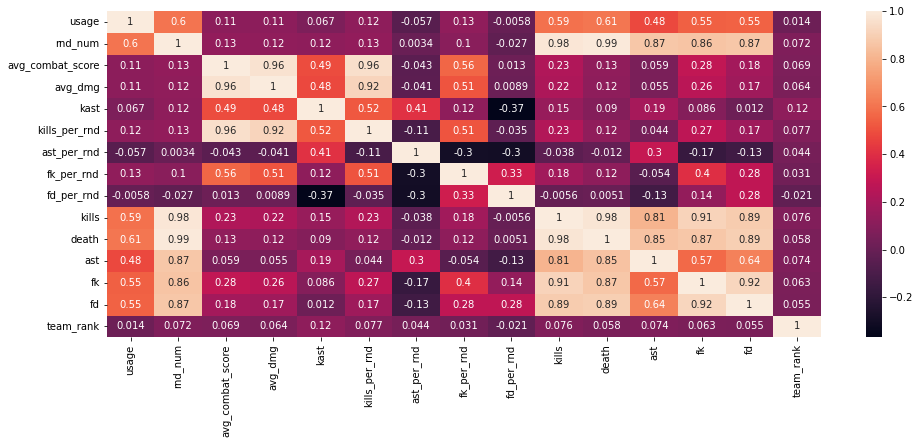

In [296]:
plt.figure(figsize=(16,6))
sns.heatmap(val_df.corr(),annot=True)

In [4]:
val_df[(val_df.current_team !='n/a')&(val_df.team_rank == 'n/a')]

Empty DataFrame
Columns: [current_team, player_name, agent_played, role_on_team, usage, rnd_num, avg_combat_score, kill_death_ratio, avg_dmg, kast, kills_per_rnd, ast_per_rnd, fk_per_rnd, fd_per_rnd, kills, death, ast, fk, fd, team_rank]
Index: []

In [5]:
val_df.dropna(subset = ['team_rank'],inplace = True)

<AxesSubplot:xlabel='role_on_team', ylabel='count'>

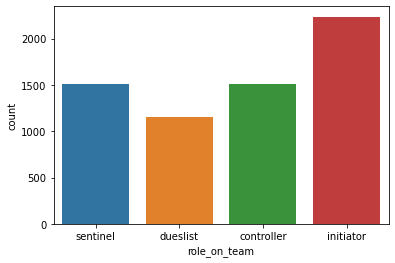

In [12]:
sns.countplot(x = val_df.role_on_team)

<AxesSubplot:xlabel='role_on_team', ylabel='kills'>

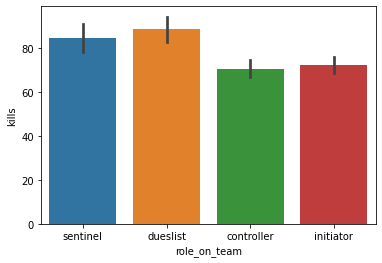

In [13]:
sns.barplot(y=val_df.kills, x=val_df.role_on_team)

<AxesSubplot:xlabel='role_on_team', ylabel='death'>

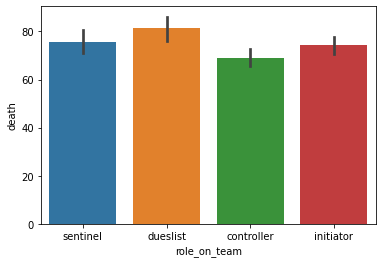

In [14]:
sns.barplot(y=abs(val_df.death), x=val_df.role_on_team)

<AxesSubplot:xlabel='role_on_team', ylabel='ast'>

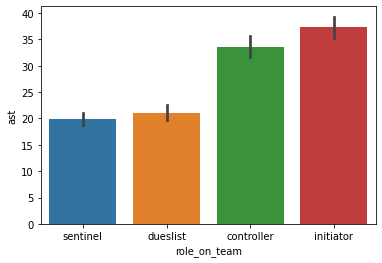

In [15]:
sns.barplot(y=val_df.ast, x=val_df.role_on_team)

<AxesSubplot:xlabel='role_on_team', ylabel='fd'>

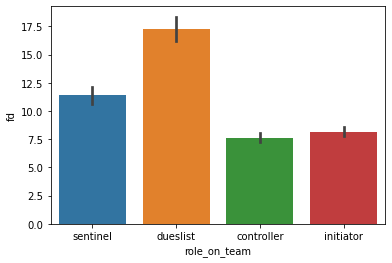

In [16]:
sns.barplot(y=abs(val_df.fd), x=val_df.role_on_team)

<AxesSubplot:xlabel='role_on_team', ylabel='fk'>

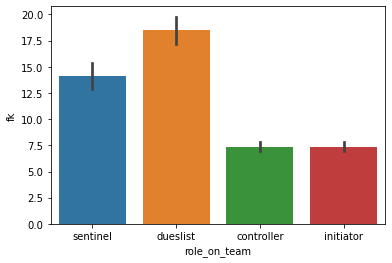

In [17]:
sns.barplot(y=val_df.fk, x=val_df.role_on_team)

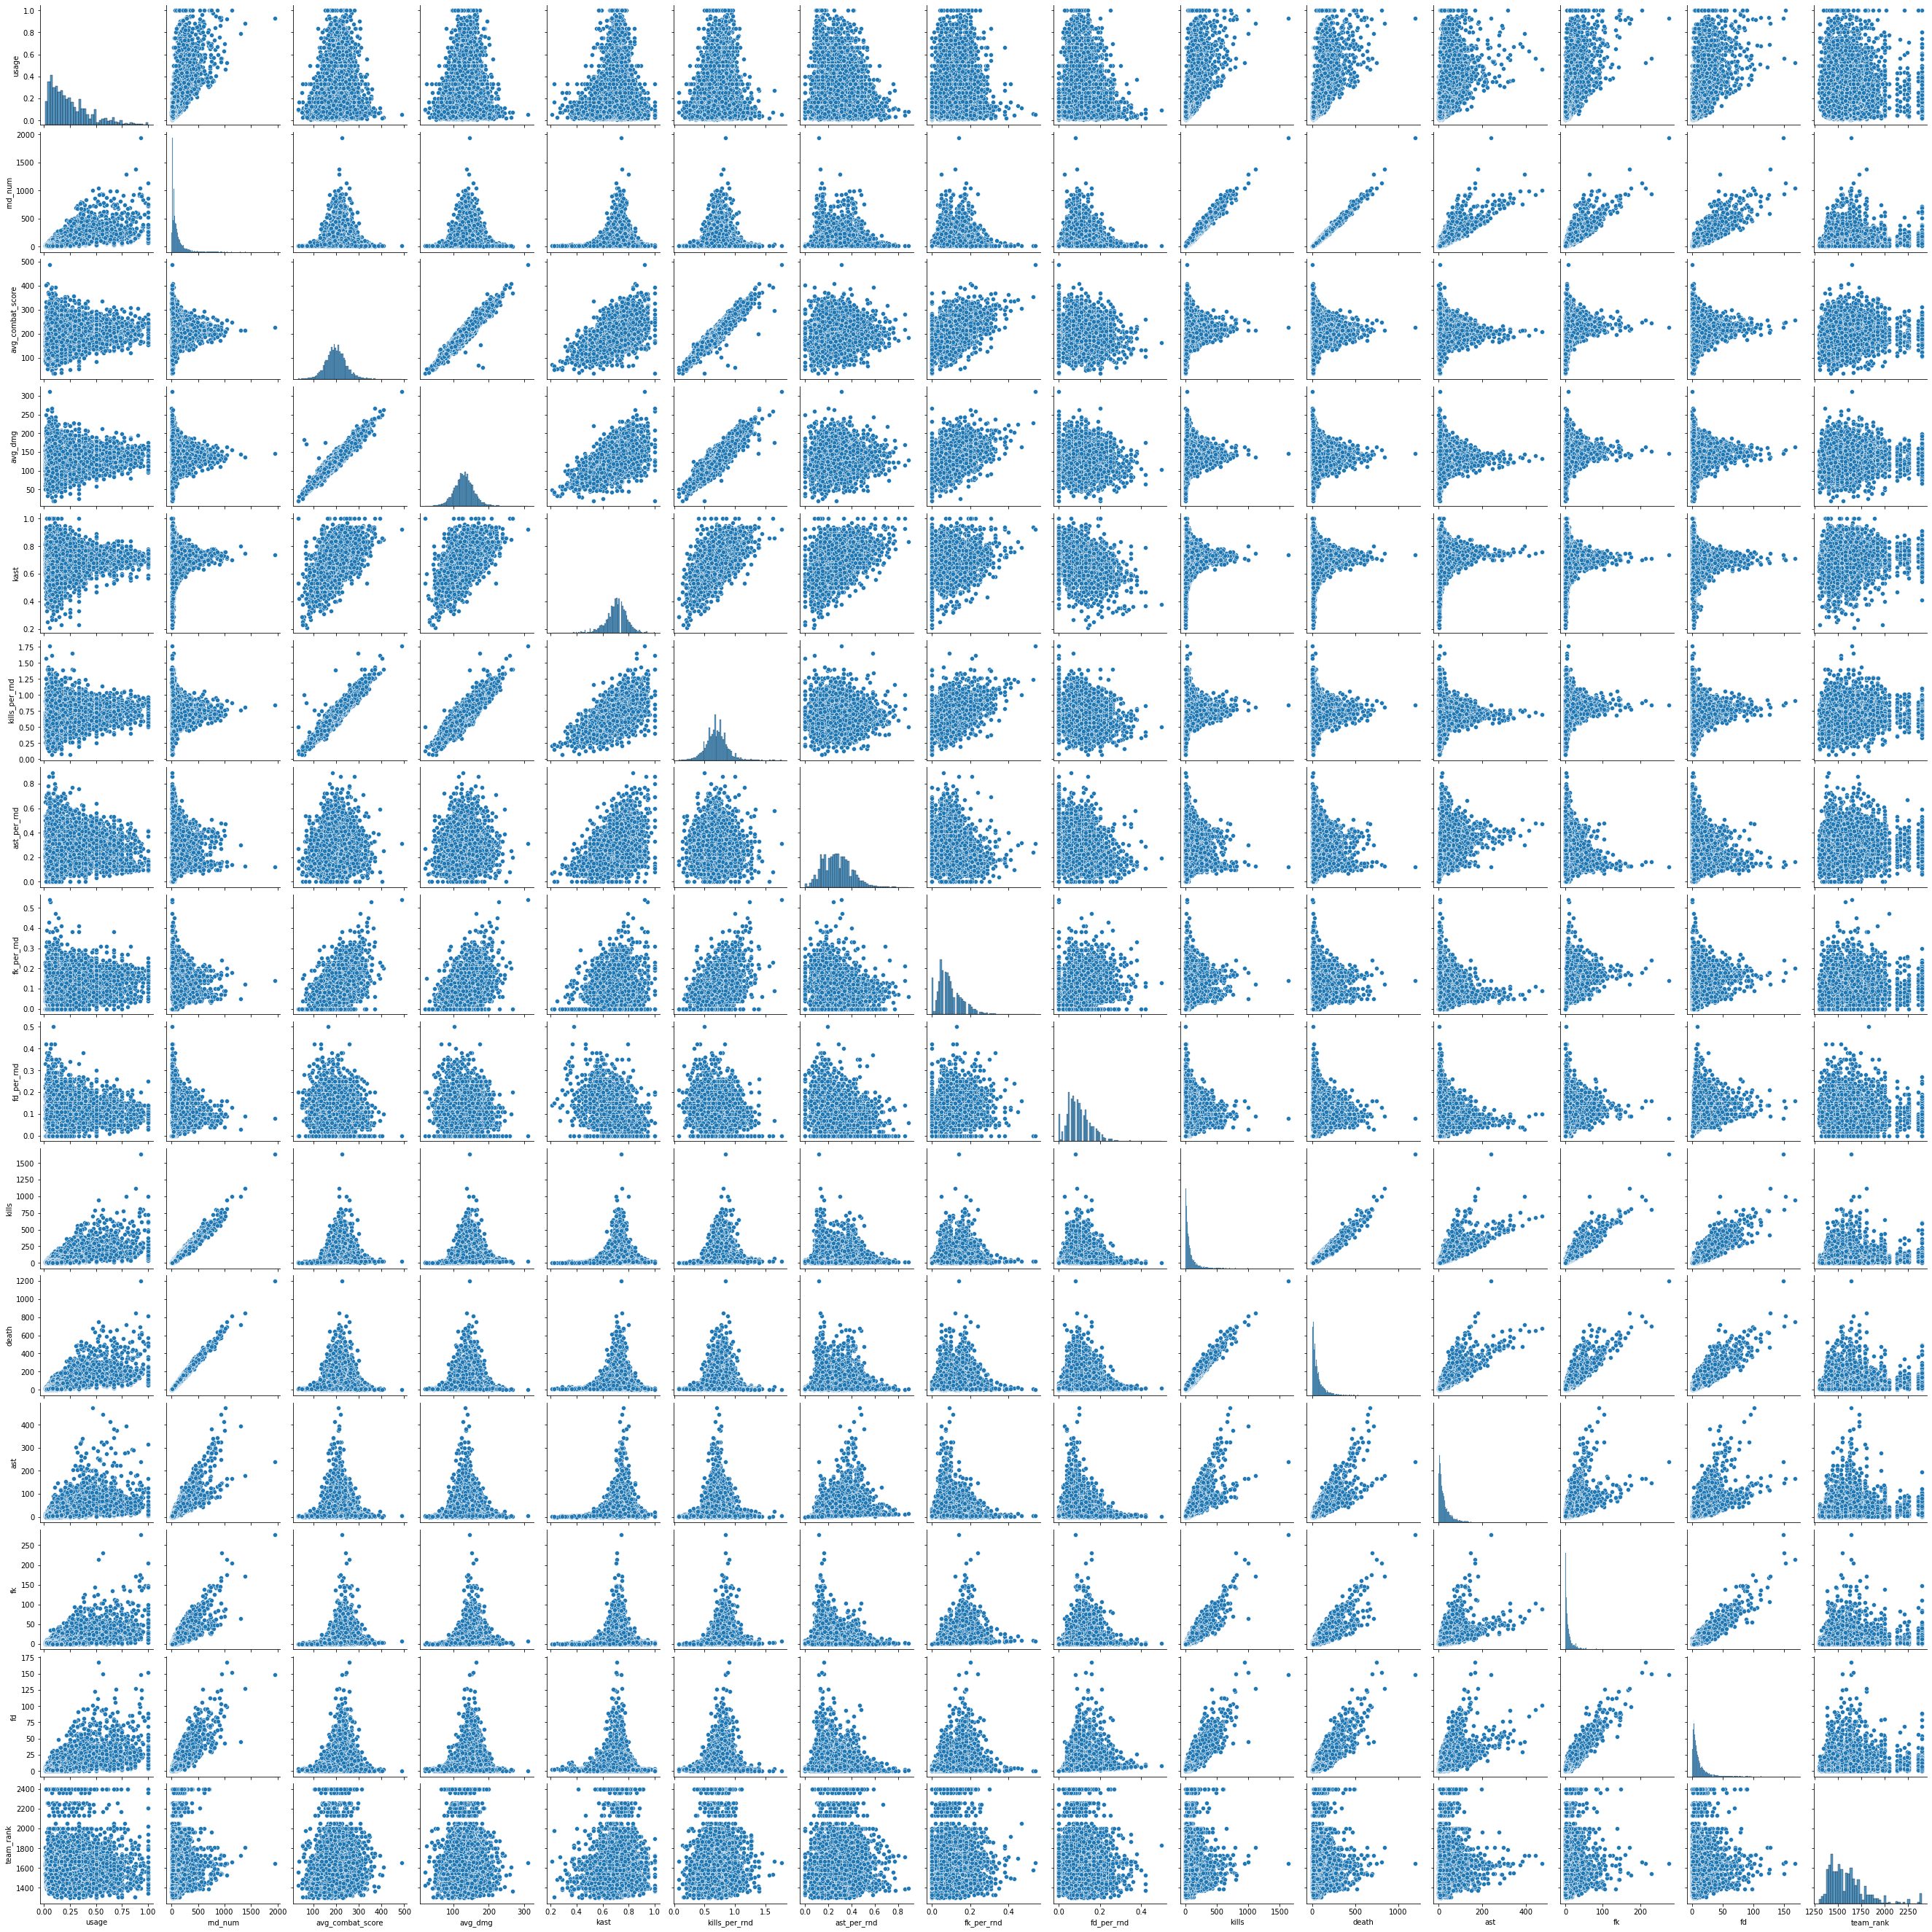

In [170]:
sns.pairplot(val_df)

# Modelling

In [6]:
#create train and test set
val_df_train, val_df_test = train_test_split(val_df, test_size=0.2, random_state=3)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [7]:
#create dummy variable to represent the role_on_team
val_df_train = pd.get_dummies(val_df_train, columns = ['role_on_team'],prefix = 'is')
val_df_test = pd.get_dummies(val_df_test, columns = ['role_on_team'],prefix = 'is')

In [8]:
#negative weight for deaths
val_df_train['fd'] = val_df_train['fd']*-1
val_df_train['death'] = val_df_train['death']*-1
val_df_test['fd'] = val_df_test['fd']*-1
val_df_test['death'] = val_df_test['death']*-1

In [9]:
#adding interaction terms
val_df_train['kills*deaths'] = val_df_train.kills*val_df_train.death
val_df_train['fk*fd'] = val_df_train.fk*val_df_train.fd
val_df_test['kills*deaths'] = val_df_test.kills*val_df_test.death
val_df_test['fk*fd'] = val_df_test.fk*val_df_test.fd

In [10]:
val_df_test[val_df_test['kill_death_ratio']=='∞']
val_df_test.drop(1827, inplace=True)

In [11]:
#Grid Search function from lasso practice exercise
def build_grid_search_est(model, x, y, cv=5, **params):

    grid_est = GridSearchCV(model, param_grid=params, cv=kfold, 
                            return_train_score=False)
    grid_est.fit(x, y)
    df = pd.DataFrame(grid_est.cv_results_)
    for param in params:
        df[param] = df.params.apply(lambda val: val[param])
        plt.semilogx(df.alpha, df.mean_test_score)
    return grid_est

In [145]:
val_df_train.head()

current_team player_name agent_played  usage  rnd_num  avg_combat_score  \
2077         Arroz         rlz         neon  0.200       58             223.0   
3996       TENSTAR    YouBreak         omen  0.091       36             190.5   
2855  Weibo Gaming         AAK      chamber  0.154       43             232.0   
7532      Reignite      hyouka         omen  0.333       23             116.0   
4220     FiRePOWER   vaLentina         sova  1.000      120             204.7   

     kill_death_ratio  avg_dmg  kast  kills_per_rnd  ...  ast  fk  fd  \
2077             1.12    129.5  0.67           0.79  ...    4   9 -13   
3996             1.24    112.1  0.67           0.72  ...   11   6  -1   
2855             1.00    138.7  0.58           0.79  ...    6   6  -8   
7532             0.56     72.0  0.70           0.43  ...    7   0  -1   
4220             1.13    138.2  0.77           0.72  ...   44   9  -4   

      team_rank  is_controller  is_duelist  is_initiator  is_sentinel  \
2077     1521.0              0           1             0            0   
3996     1493.0              1           0             0            0   
2855     1740.0              0           0             0            1   
7532     1630.0              1           0             0            0   
4220     1710.0              0           0             1            0   

      kills*deaths  fk*fd  
2077         -1886   -117  
3996          -546     -6  
2855         -1156    -48  
7532          -180      0  
4220         -6536    -36  

[5 rows x 25 columns]

#### Initial Modeling without many filters

In [11]:
y_unfiltered = val_df_train['team_rank']
x_unfiltered =  val_df_train.drop(['current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)
x_unfiltered = sm.add_constant(x_unfiltered)
unfiltered_model = sm.OLS(y_unfiltered,x_unfiltered).fit()
unfiltered_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     9.547
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           1.27e-26
Time:                        23:09:21   Log-Likelihood:                -34247.
No. Observations:                5065   AIC:                         6.853e+04
Df Residuals:                    5046   BIC:                         6.866e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1199.6496     26.202     45.785      0.000    1148.283    1251.016
avg_combat_score    -0.2333      0.374     -0.624      0.532      -0.966       0.499
kill_death_ratio    39.9248     19.473      2.050      0.040       1.749      78.101
avg_dmg             -0.1794      0.404     -0.444      0.657      -0.972       0.613
kast               220.2823     51.285      4.295      0.000     119.742     320.823
kills_per_rnd      -59.2719     82.265     -0.721      0.471    -220.546     102.003
ast_per_rnd        -26.7032     38.788     -0.688      0.491    -102.744      49.337
fk_per_rnd          66.5966     86.882      0.767      0.443    -103.731     236.924
fd_per_rnd         109.5679     77.484      1.414      0.157     -42.334     261.470
kills                1.6635      0.275      6.047      0.000       1.124       2.203
death                1.7271      0.288      5.990      0.000       1.162       2.292
ast                  0.7076      0.264      2.681      0.007       0.190       1.225
fk                  -0.9173      1.096     -0.837      0.403      -3.066       1.232
fd                  -0.7845      1.013     -0.774      0.439      -2.771       1.202
is_controller      297.7196      8.359     35.615      0.000     281.332     314.108
is_duelist         297.4054     11.088     26.823      0.000     275.668     319.142
is_initiator       309.5937      8.211     37.703      0.000     293.496     325.691
is_sentinel        294.9310      8.441     34.941      0.000     278.383     311.479
kills*deaths         0.0007      0.000      3.109      0.002       0.000       0.001
fk*fd               -0.0114      0.009     -1.229      0.219      -0.030       0.007
==============================================================================
Omnibus:                     1553.942   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4444.533
Skew:                           1.616   Prob(JB):                         0.00
Kurtosis:                       6.258   Cond. No.                     2.54e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.01e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

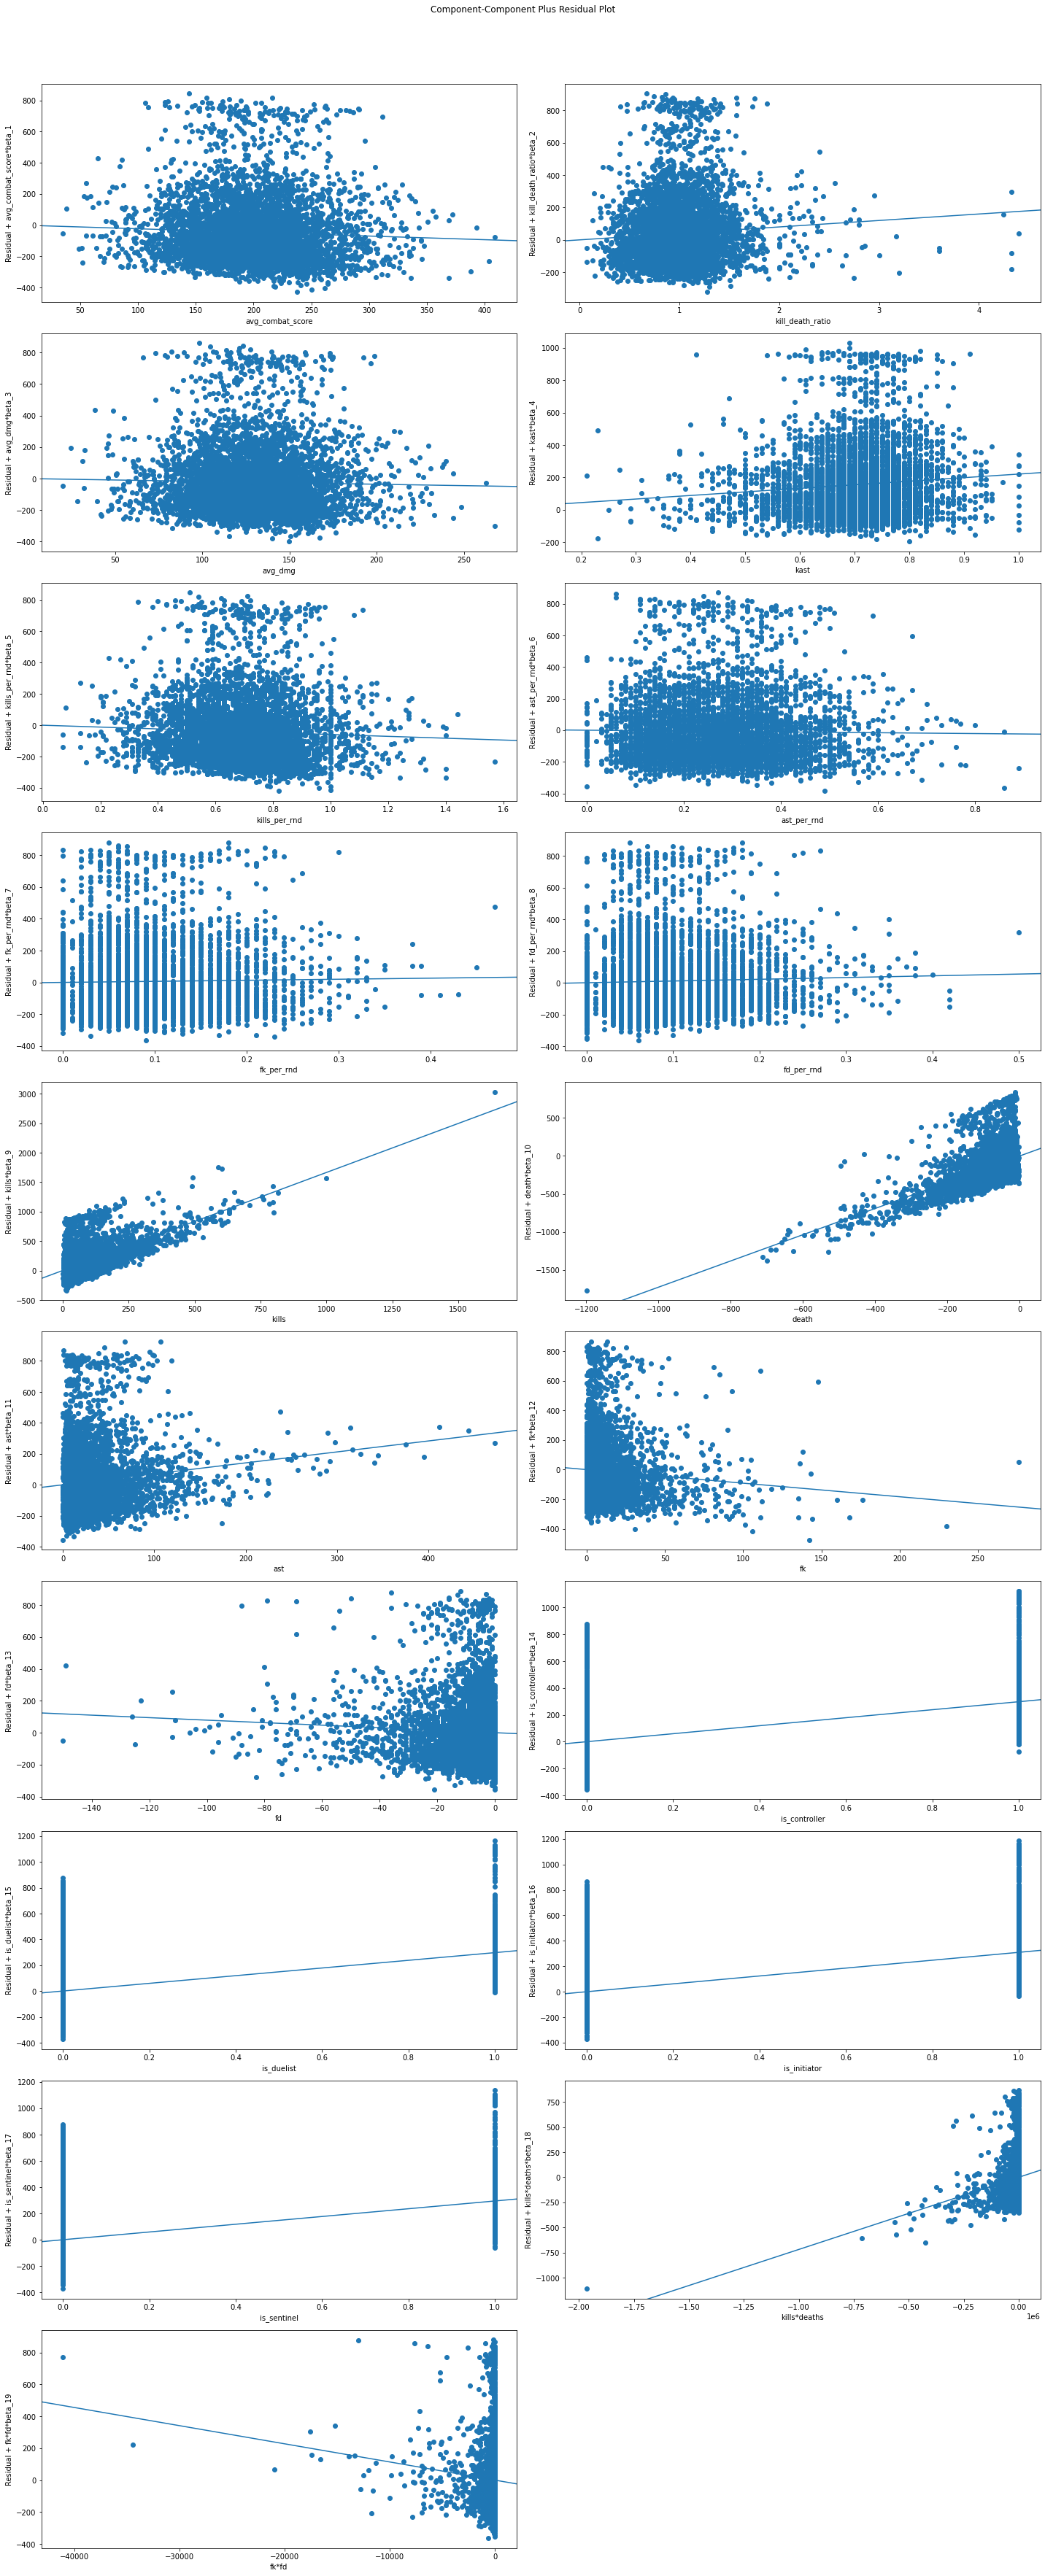

In [14]:
fig = plt.figure(figsize=(20,50))
data = val_df_train
sm.graphics.plot_ccpr_grid(unfiltered_model,fig=fig)
plt.show()

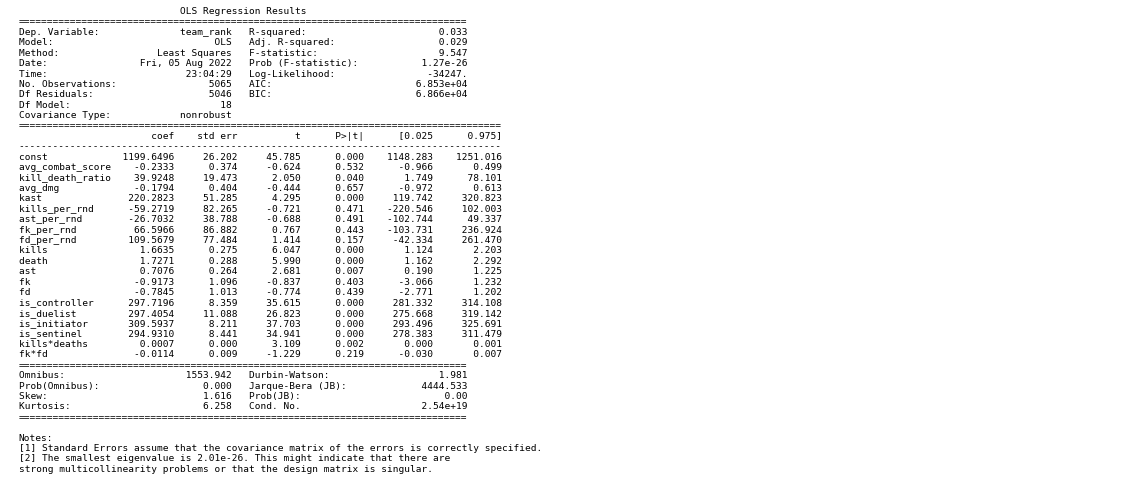

In [180]:
plt.rc('figure', figsize=(16, 7))
plt.text(0.01, 0.05, str(unfiltered_model.summary()), {'fontsize': 9.5}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('output1.png')

In [142]:
y_test_unfiltered = val_df_test['team_rank']
x_test_unfiltered =  val_df_test.drop(['current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)
x_test_unfiltered = sm.add_constant(x_test_unfiltered)

0           1
0              const    0.000000
1   avg_combat_score   -0.328603
2   kill_death_ratio   32.307382
3            avg_dmg   -0.188756
4               kast  176.319815
5      kills_per_rnd   -0.000000
6        ast_per_rnd   -2.034428
7         fk_per_rnd    1.094296
8         fd_per_rnd   42.248404
9              kills    1.570486
10             death    1.781086
11               ast    0.724747
12                fk   -0.349724
13                fd   -1.241957
14     is_controller   -1.723474
15        is_duelist    2.455503
16      is_initiator    9.388695
17       is_sentinel   -2.079843
18      kills*deaths    0.000603
19             fk*fd   -0.005845

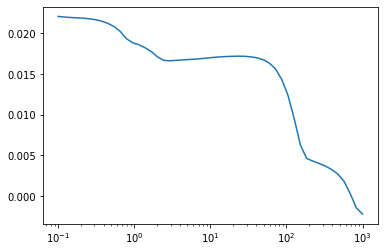

In [14]:
unfiltered_lasso = build_grid_search_est(Lasso(),x_unfiltered,y_unfiltered,cv=kfold, alpha=np.logspace(-1,3))
pd.DataFrame(list(zip(x_unfiltered.columns,unfiltered_lasso.best_estimator_.coef_)))

#### Second Model based on Lasso results

Filter out additional stat columns based on suspected multicollinearity. 

In [17]:
#filter based on Lasso Results
y = val_df_train['team_rank']
x = val_df_train.drop(['avg_combat_score','avg_dmg','ast_per_rnd','fk_per_rnd','fd_per_rnd','kills_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)

y_test = val_df_test['team_rank']
x_test = val_df_test.drop(['avg_dmg','kills_per_rnd','kill_death_ratio','fk_per_rnd','fd_per_rnd','ast_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)

x = sm.add_constant(x)

In [18]:
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     12.65
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           6.52e-26
Time:                        18:11:12   Log-Likelihood:                -34257.
No. Observations:                5065   AIC:                         6.854e+04
Df Residuals:                    5052   BIC:                         6.862e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1184.6106     21.392     55.375      0.000    1142.672    1226.549
kill_death_ratio    -5.9665     12.949     -0.461      0.645     -31.352      19.419
kast               171.0280     45.131      3.790      0.000      82.551     259.505
kills                1.4742      0.249      5.914      0.000       0.985       1.963
death                1.6975      0.268      6.344      0.000       1.173       2.222
ast                  0.6949      0.224      3.104      0.002       0.256       1.134
fk                  -0.7406      0.829     -0.894      0.371      -2.365       0.884
fd                  -1.5657      0.812     -1.928      0.054      -3.158       0.026
is_controller      294.2030      7.831     37.569      0.000     278.851     309.555
is_duelist         290.2176      8.659     33.516      0.000     273.242     307.193
is_initiator       305.9486      7.622     40.138      0.000     291.005     320.892
is_sentinel        294.2413      7.578     38.831      0.000     279.386     309.097
kills*deaths         0.0005      0.000      2.512      0.012       0.000       0.001
fk*fd               -0.0065      0.008     -0.792      0.428      -0.023       0.010
==============================================================================
Omnibus:                     1558.555   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4465.858
Skew:                           1.620   Prob(JB):                         0.00
Kurtosis:                       6.265   Cond. No.                     9.91e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.32e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

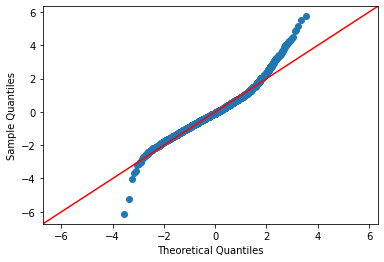

In [19]:
sm.qqplot(model.predict(), fit=True,line='45')
plt.show()

In [20]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,x,y,cv=kfold)
print(scores)
print("Linear Reg Mean Score: ", np.mean(scores))

[0.02677647 0.02131346 0.01392414 0.0209726  0.01908298]
Linear Reg Mean Score:  0.020413931871844038


In [21]:
lin_reg.fit(x, y)
train_pred=lin_reg.predict (x)
print("Train Score: ", r2_score(y,train_pred))

Train Score:  0.029169021533311024


Text(0.5, 1.0, 'Residuals vs. Predictions')

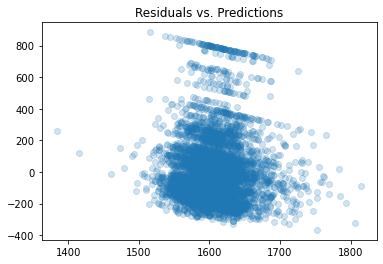

In [27]:
lin_reg_residuals = y - train_pred

plt.scatter(train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

#### Filter further based on Team Elo.

Highest ranks seem to have the highest cluster of players getting very similar stats.

Leads me to believe that individual performance matters less at a higher level.

In [16]:
y_rank = val_df_train['team_rank'][val_df_train['team_rank']<2000]
x_rank = val_df_train[val_df_train['team_rank']<2000].drop(['avg_combat_score','avg_dmg','ast_per_rnd','fk_per_rnd','fd_per_rnd','kills_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)
x_rank = sm.add_constant(x_rank)

y_test_rank = val_df_test['team_rank'][val_df_test['team_rank']<2000]
x_test_rank = val_df_test[val_df_test['team_rank']<2000].drop(['avg_combat_score','avg_dmg','ast_per_rnd','fk_per_rnd','fd_per_rnd','kills_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num'],axis=1).astype(float)
x_test_rank = sm.add_constant(x_test_rank)

In [17]:
rank_model = sm.OLS(y_rank,x_rank).fit()
rank_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     13.44
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           9.10e-28
Time:                        23:23:54   Log-Likelihood:                -30635.
No. Observations:                4781   AIC:                         6.130e+04
Df Residuals:                    4768   BIC:                         6.138e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1187.2878     15.256     77.824      0.000    1157.379    1217.197
kill_death_ratio    -3.4039      9.234     -0.369      0.712     -21.508      14.700
kast               122.4972     32.237      3.800      0.000      59.298     185.697
kills                1.0398      0.180      5.787      0.000       0.688       1.392
death                1.5279      0.192      7.941      0.000       1.151       1.905
ast                  0.7213      0.161      4.487      0.000       0.406       1.036
fk                  -0.8451      0.605     -1.397      0.162      -2.031       0.341
fd                  -2.5051      0.586     -4.271      0.000      -3.655      -1.355
is_controller      291.4917      5.621     51.855      0.000     280.471     302.512
is_duelist         293.0587      6.197     47.290      0.000     280.910     305.208
is_initiator       300.6279      5.475     54.910      0.000     289.895     311.361
is_sentinel        302.1095      5.417     55.771      0.000     291.490     312.729
kills*deaths      8.003e-05      0.000      0.525      0.600      -0.000       0.000
fk*fd                0.0006      0.006      0.105      0.916      -0.011       0.012
==============================================================================
Omnibus:                      287.203   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.895
Skew:                           0.630   Prob(JB):                     2.31e-72
Kurtosis:                       2.734   Cond. No.                     4.73e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.58e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

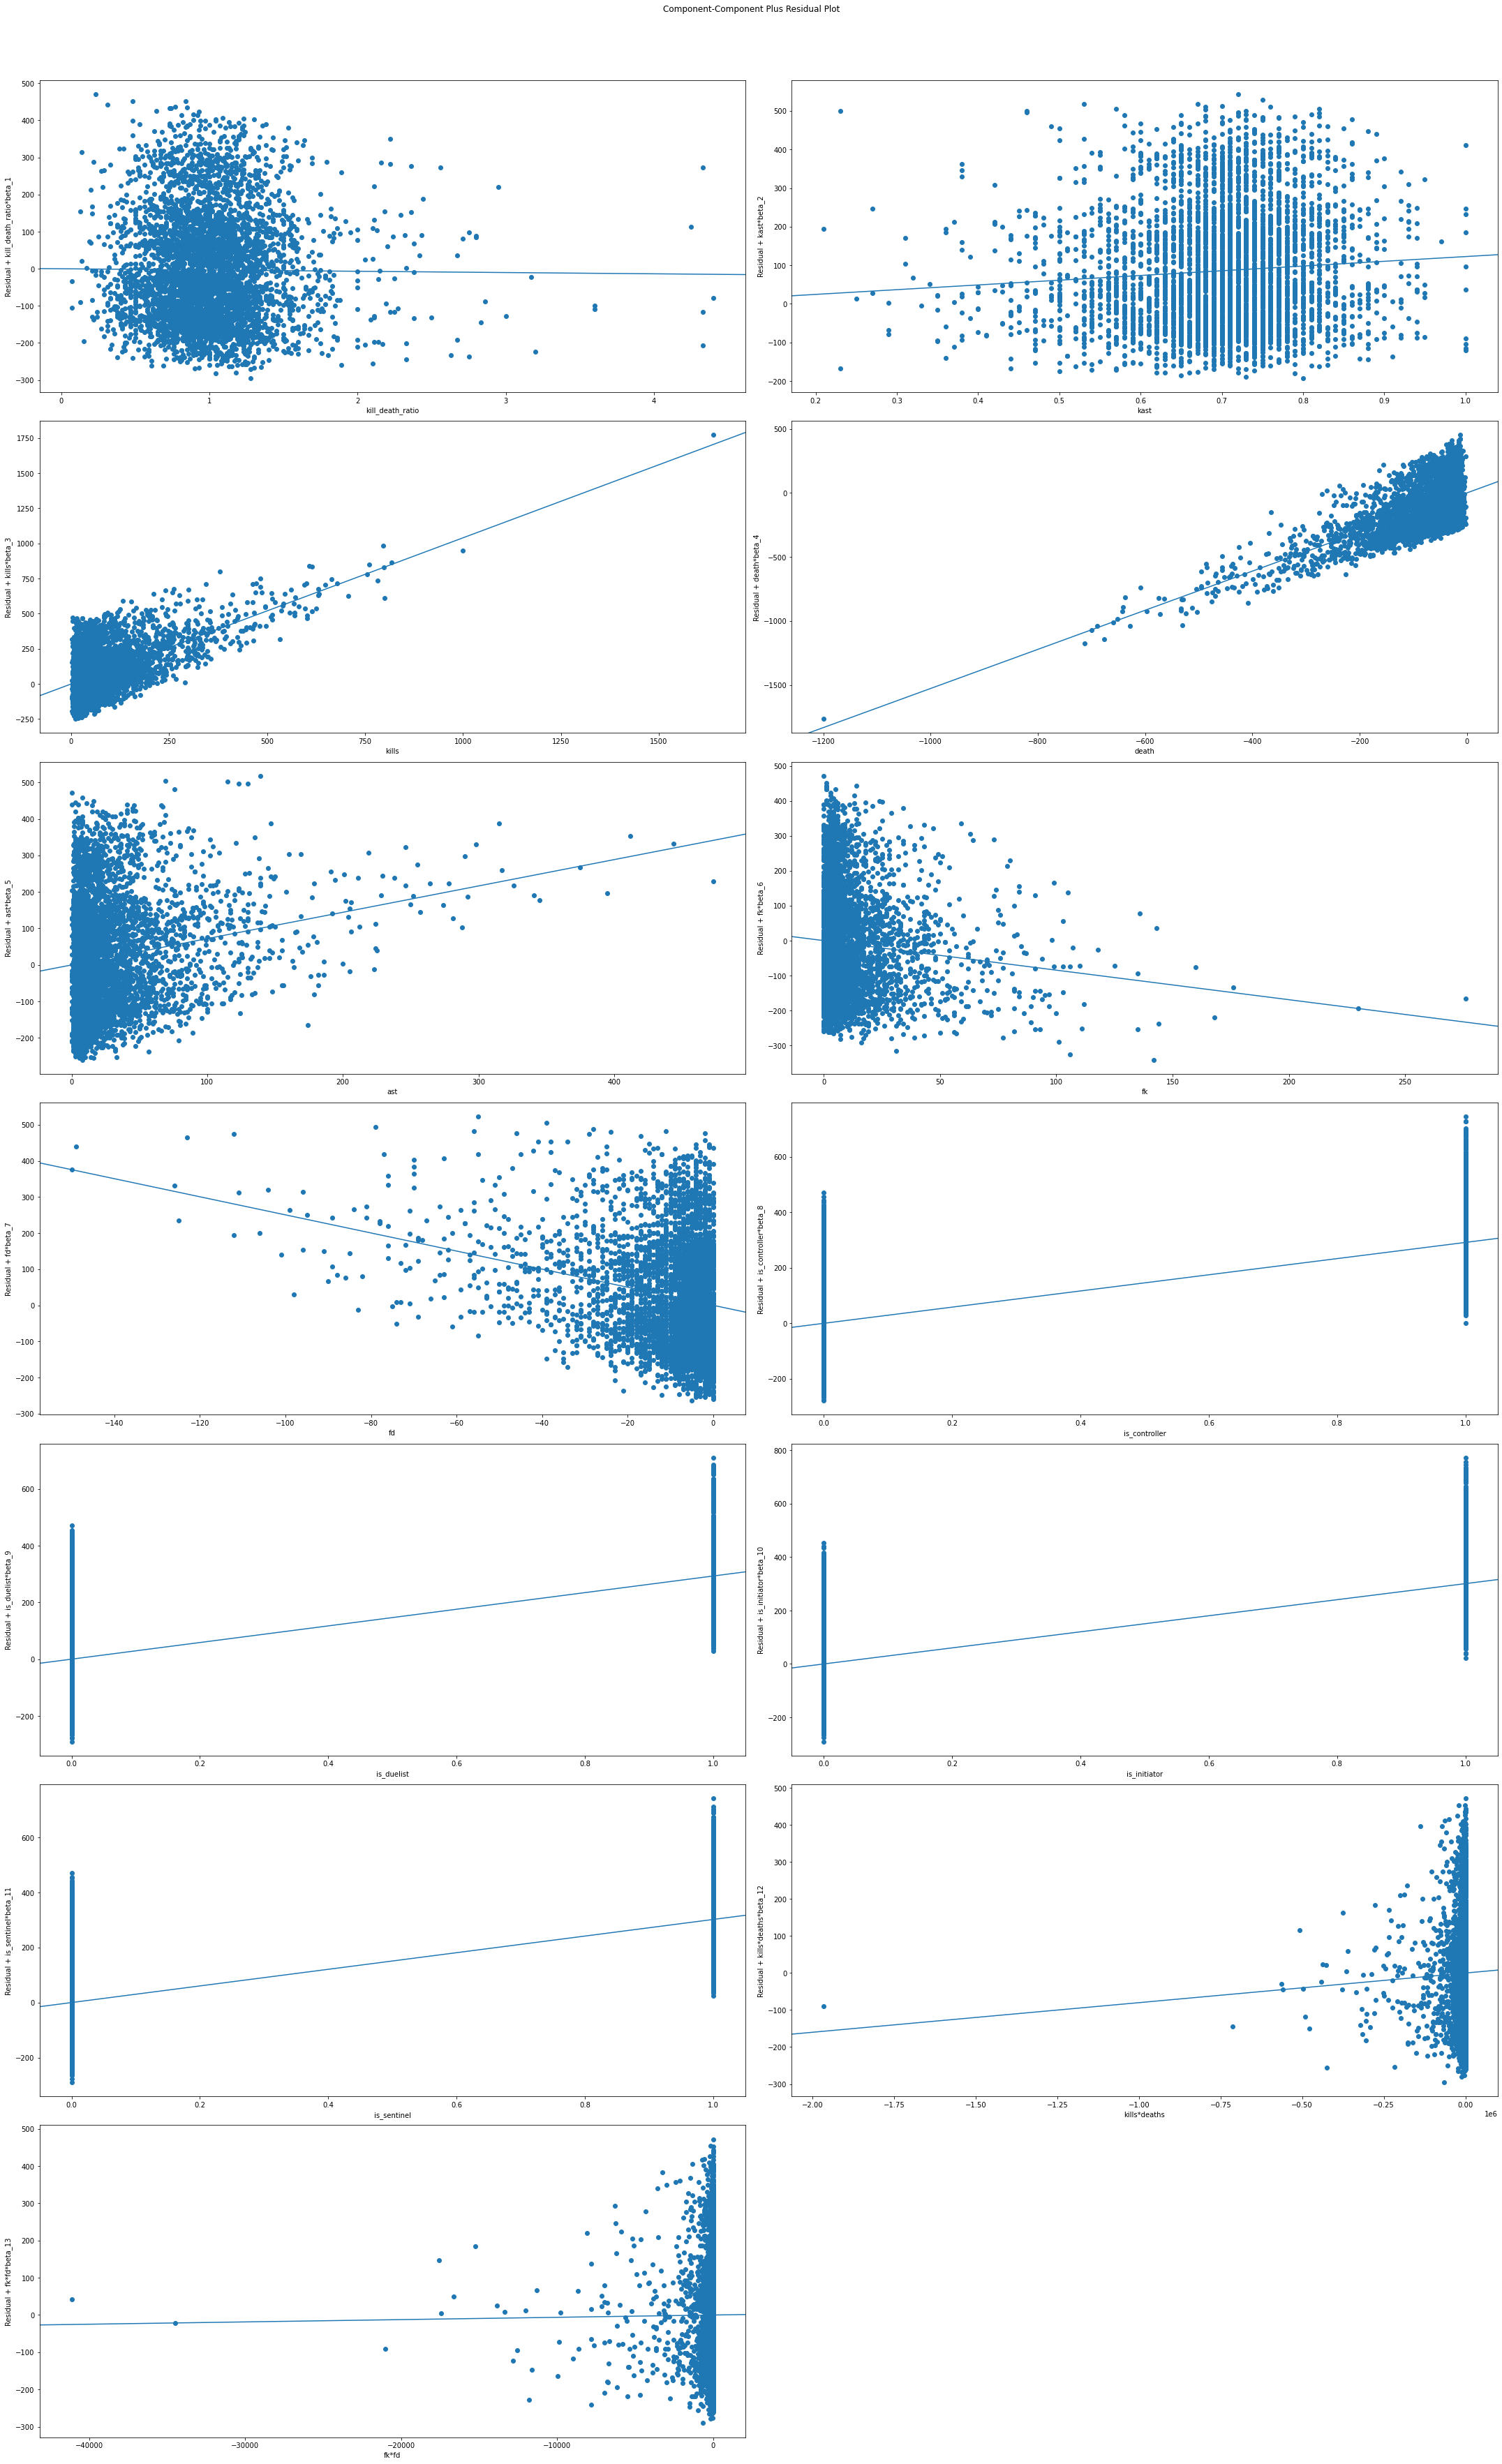

In [19]:
fig = plt.figure(figsize=(30,50))
sm.graphics.plot_ccpr_grid(rank_model,fig=fig)
plt.show()

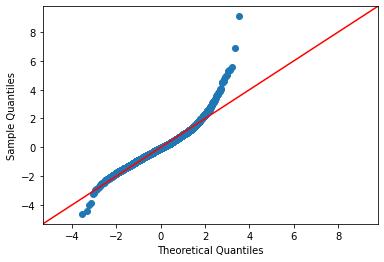

In [30]:
sm.qqplot(rank_model.predict(), fit=True,line='45')
plt.show()

#### Model based on the role played along with previous filters

Impact of a role hasn't been clearly demonstrated. Perhaps on paper stats matter more for some roles than others.

In [12]:
#lets try improving model by building models with role specific filters
y_duelist = val_df_train['team_rank'][(val_df_train['is_duelist']==1) & (val_df_train['team_rank']<2000)]
x_duelist = val_df_train[(val_df_train['is_duelist']==1) & (val_df_train['team_rank']<2000)].drop(['avg_combat_score','kast','avg_dmg','kills_per_rnd','kill_death_ratio','fk_per_rnd','fd_per_rnd','ast_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num','is_controller','is_duelist','is_initiator','is_sentinel'],axis=1).astype(float)
#standardization#x_duelist = ((x_duelist[['kills','ast','fk','fd']]-x_duelist[['kills','ast','fk','fd']].mean())/x_duelist[['kills','ast','fk','fd']].std())
x_duelist = sm.add_constant(x_duelist)

y_controller = val_df_train['team_rank'][(val_df_train['is_controller']==1) & (val_df_train['team_rank']<2000)]
x_controller = val_df_train[(val_df_train['is_controller']==1) & (val_df_train['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
#standardization#x_controller = ((x_controller[['kills','ast','fk','fd']]-x_controller[['kills','ast','fk','fd']].mean())/x_controller[['kills','ast','fk','fd']].std())
x_controller = sm.add_constant(x_controller)

y_initiator = val_df_train['team_rank'][(val_df_train['is_initiator']==1) & (val_df_train['team_rank']<2000)]
x_initiator = val_df_train[(val_df_train['is_initiator']==1) & (val_df_train['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
#standardization#x_initiator = ((x_initiator[['kills','ast','fk','fd']]-x_initiator[['kills','ast','fk','fd']].mean())/x_initiator[['kills','ast','fk','fd']].std())
x_initiator = sm.add_constant(x_initiator)

y_sentinel = val_df_train['team_rank'][(val_df_train['is_sentinel']==1) & (val_df_train['team_rank']<2000)]
x_sentinel = val_df_train[(val_df_train['is_sentinel']==1) & (val_df_train['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
#standardization#x_sentinel = ((x_sentinel[['kills','ast','fk','fd']]-x_sentinel[['kills','ast','fk','fd']].mean())/x_sentinel[['kills','ast','fk','fd']].std())
x_sentinel = sm.add_constant(x_sentinel)

In [13]:
y_test_duelist = val_df_test['team_rank'][(val_df_test['is_duelist']==1) & (val_df_test['team_rank']<2000)]
x_test_duelist = val_df_test[(val_df_test['is_duelist']==1) & (val_df_test['team_rank']<2000)].drop(['avg_combat_score','kast','avg_dmg','kills_per_rnd','kill_death_ratio','fk_per_rnd','fd_per_rnd','ast_per_rnd','current_team','player_name','agent_played','team_rank','usage','rnd_num','is_controller','is_duelist','is_initiator','is_sentinel'],axis=1).astype(float)
x_test_duelist = sm.add_constant(x_test_duelist)

y_test_controller = val_df_test['team_rank'][(val_df_test['is_controller']==1) & (val_df_test['team_rank']<2000)]
x_test_controller = val_df_test[(val_df_test['is_controller']==1) & (val_df_test['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
x_test_controller = sm.add_constant(x_test_controller)

y_test_initiator = val_df_test['team_rank'][(val_df_test['is_initiator']==1) & (val_df_test['team_rank']<2000)]
x_test_initiator = val_df_test[(val_df_test['is_initiator']==1) & (val_df_test['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
x_test_initiator = sm.add_constant(x_test_initiator)

y_test_sentinel = val_df_test['team_rank'][(val_df_test['is_sentinel']==1) & (val_df_test['team_rank']<2000)]
x_test_sentinel = val_df_test[(val_df_test['is_sentinel']==1) & (val_df_test['team_rank']<2000)][['kills','death','ast','fk','fd','kills*deaths','fk*fd']].astype(float)
x_test_sentinel = sm.add_constant(x_test_sentinel)

In [153]:
#standardized_x = ((x[['kills','ast','fk','fd']]-x[['kills','ast','fk','fd']].mean())/x[['kills','ast','fk','fd']].std())
#x_train = standardized_x.join(x[['is_controller','is_duelist','is_initiator','is_sentinel']])

In [14]:
duelist_model = sm.OLS(y_duelist,x_duelist).fit()
duelist_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.510
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           3.26e-06
Time:                        18:35:24   Log-Likelihood:                -5521.8
No. Observations:                 862   AIC:                         1.106e+04
Df Residuals:                     854   BIC:                         1.110e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1566.2751      8.601    182.113      0.000    1549.394    1583.156
kills            1.1664      0.417      2.797      0.005       0.348       1.985
death            2.5547      0.468      5.462      0.000       1.637       3.473
ast              1.0898      0.674      1.616      0.107      -0.234       2.414
fk               1.0482      1.326      0.791      0.429      -1.554       3.650
fd              -3.7591      1.235     -3.044      0.002      -6.183      -1.335
kills*deaths    -0.0005      0.001     -0.639      0.523      -0.002       0.001
fk*fd            0.0097      0.014      0.672      0.502      -0.019       0.038
==============================================================================
Omnibus:                       50.224   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.853
Skew:                           0.593   Prob(JB):                     1.23e-12
Kurtosis:                       2.656   Cond. No.                     7.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

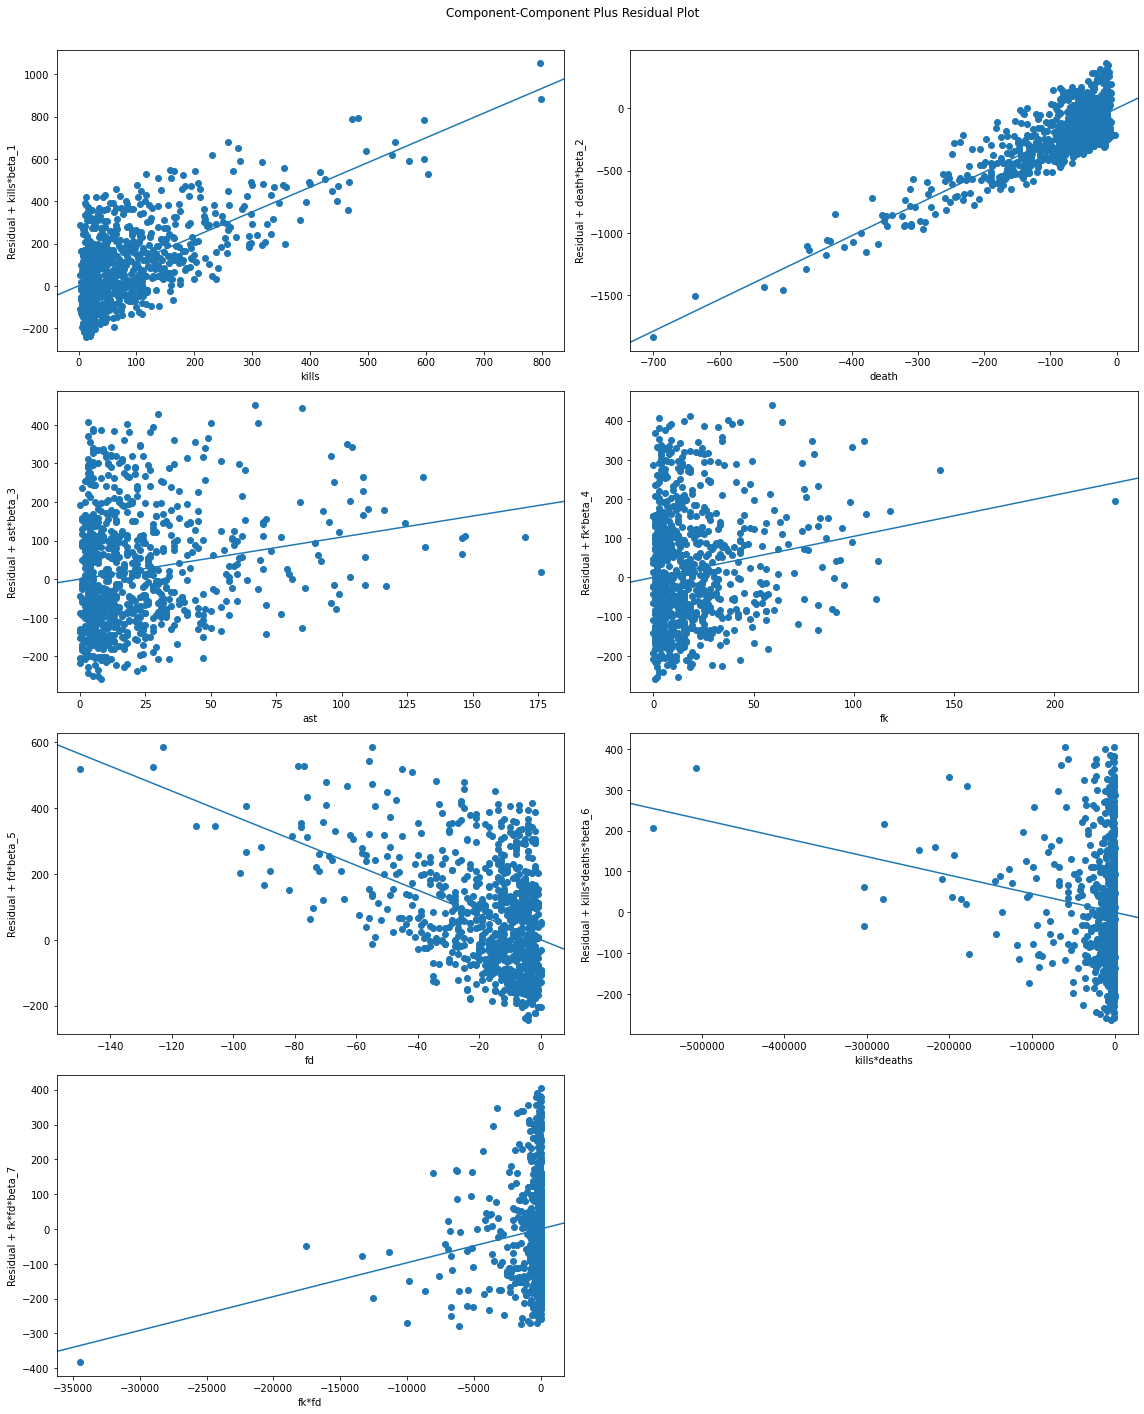

In [36]:
fig = plt.figure(figsize=(16,20))
sm.graphics.plot_ccpr_grid(duelist_model,fig=fig)
plt.show()

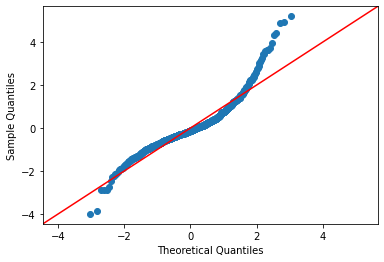

In [38]:
sm.qqplot(duelist_model.predict(), fit=True,line='45')
plt.show()

C:\Users\Angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


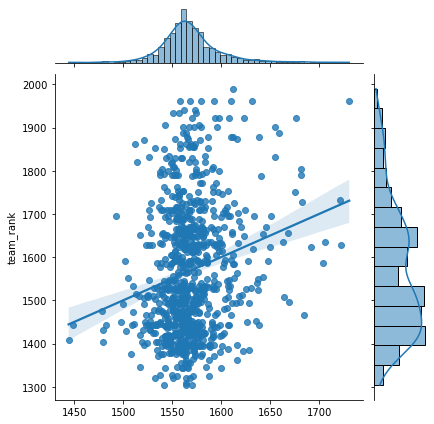

In [19]:
sns.jointplot(duelist_model.predict(x_duelist), y_duelist, kind='reg')

In [16]:
controller_model = sm.OLS(y_controller,x_controller).fit()
controller_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     4.414
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           7.52e-05
Time:                        18:35:28   Log-Likelihood:                -7303.2
No. Observations:                1139   AIC:                         1.462e+04
Df Residuals:                    1131   BIC:                         1.466e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1556.5102      7.625    204.127      0.000    1541.549    1571.471
kills            1.1667      0.356      3.279      0.001       0.469       1.865
death            1.4251      0.381      3.745      0.000       0.678       2.172
ast              1.0389      0.394      2.639      0.008       0.266       1.811
fk              -2.3477      1.867     -1.258      0.209      -6.010       1.315
fd              -1.6735      1.796     -0.932      0.352      -5.197       1.850
kills*deaths     0.0005      0.001      0.705      0.481      -0.001       0.002
fk*fd           -0.0094      0.054     -0.173      0.862      -0.116       0.097
==============================================================================
Omnibus:                       75.455   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.293
Skew:                           0.680   Prob(JB):                     4.08e-20
Kurtosis:                       2.824   Cond. No.                     5.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

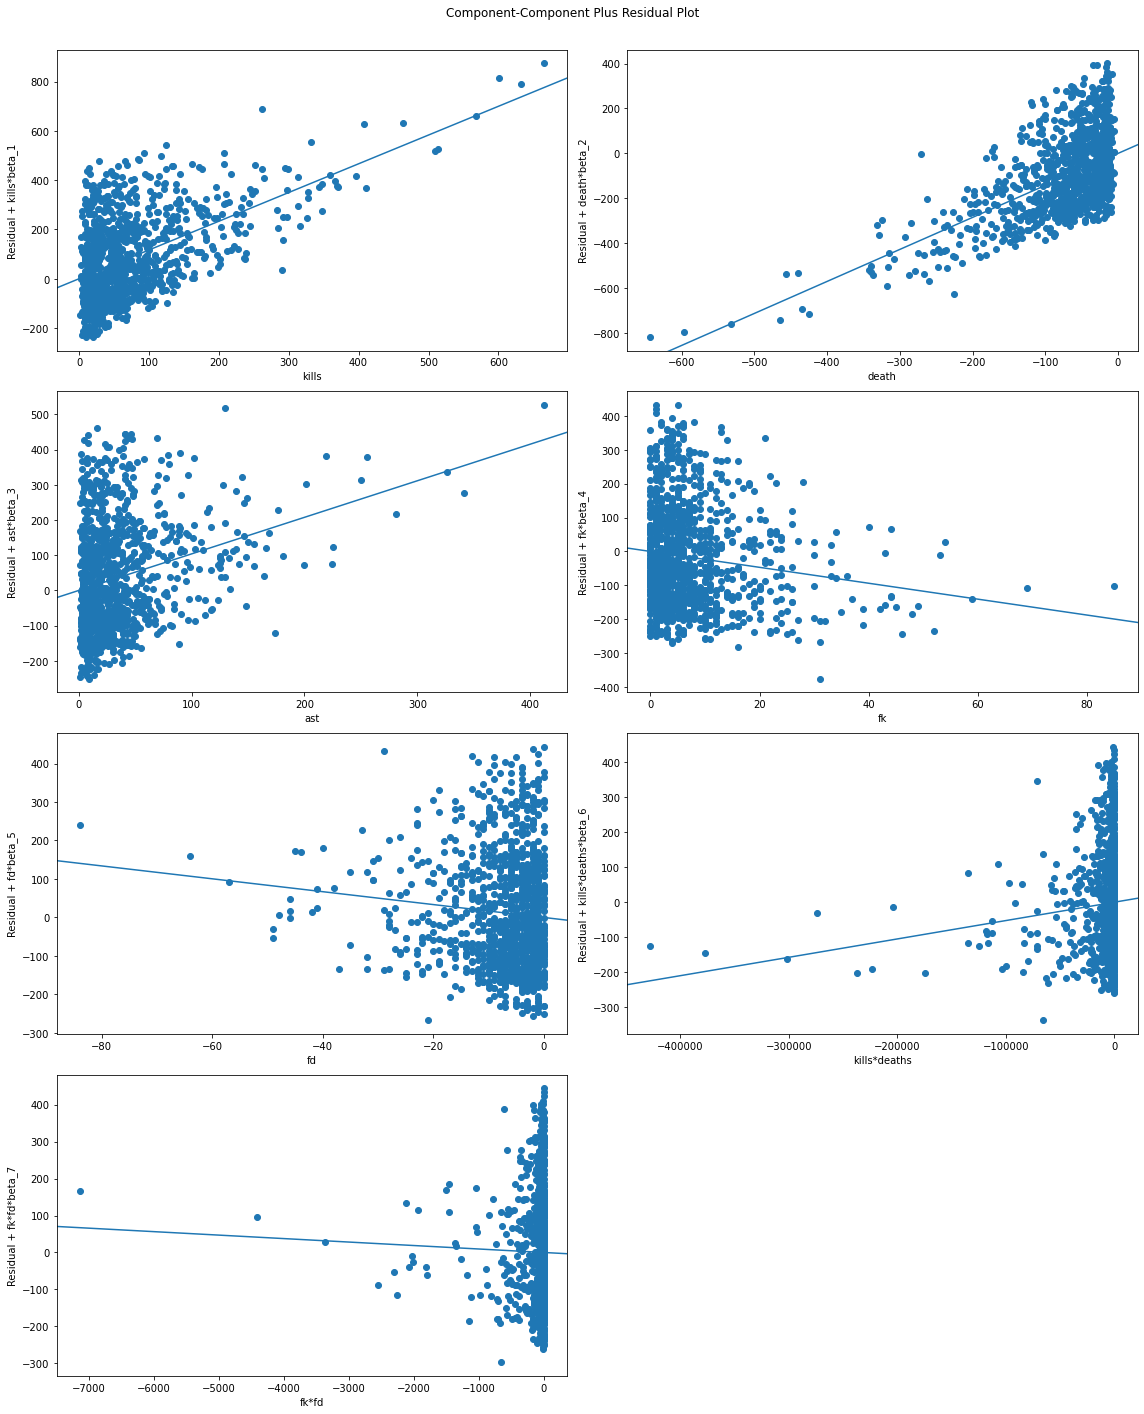

In [37]:
fig = plt.figure(figsize=(16,20))
sm.graphics.plot_ccpr_grid(controller_model,fig=fig)
plt.show()

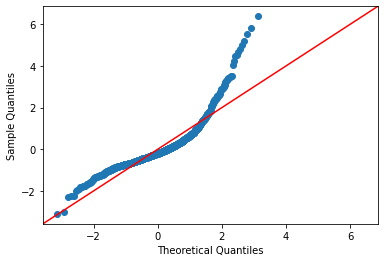

In [44]:
sm.qqplot(controller_model.predict(), fit=True,line='45')
plt.show()

In [17]:
initiator_model = sm.OLS(y_initiator,x_initiator).fit()
initiator_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     6.487
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           1.46e-07
Time:                        18:35:31   Log-Likelihood:                -10549.
No. Observations:                1645   AIC:                         2.111e+04
Df Residuals:                    1637   BIC:                         2.116e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1567.8596      5.921    264.787      0.000    1556.246    1579.474
kills            1.3315      0.276      4.823      0.000       0.790       1.873
death            1.4683      0.276      5.319      0.000       0.927       2.010
ast              0.8016      0.312      2.572      0.010       0.190       1.413
fk              -2.8520      1.448     -1.970      0.049      -5.692      -0.012
fd              -1.5460      1.222     -1.265      0.206      -3.943       0.851
kills*deaths     0.0005      0.000      1.564      0.118      -0.000       0.001
fk*fd           -0.0207      0.023     -0.901      0.368      -0.066       0.024
==============================================================================
Omnibus:                      108.054   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.574
Skew:                           0.669   Prob(JB):                     3.27e-28
Kurtosis:                       2.759   Cond. No.                     6.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

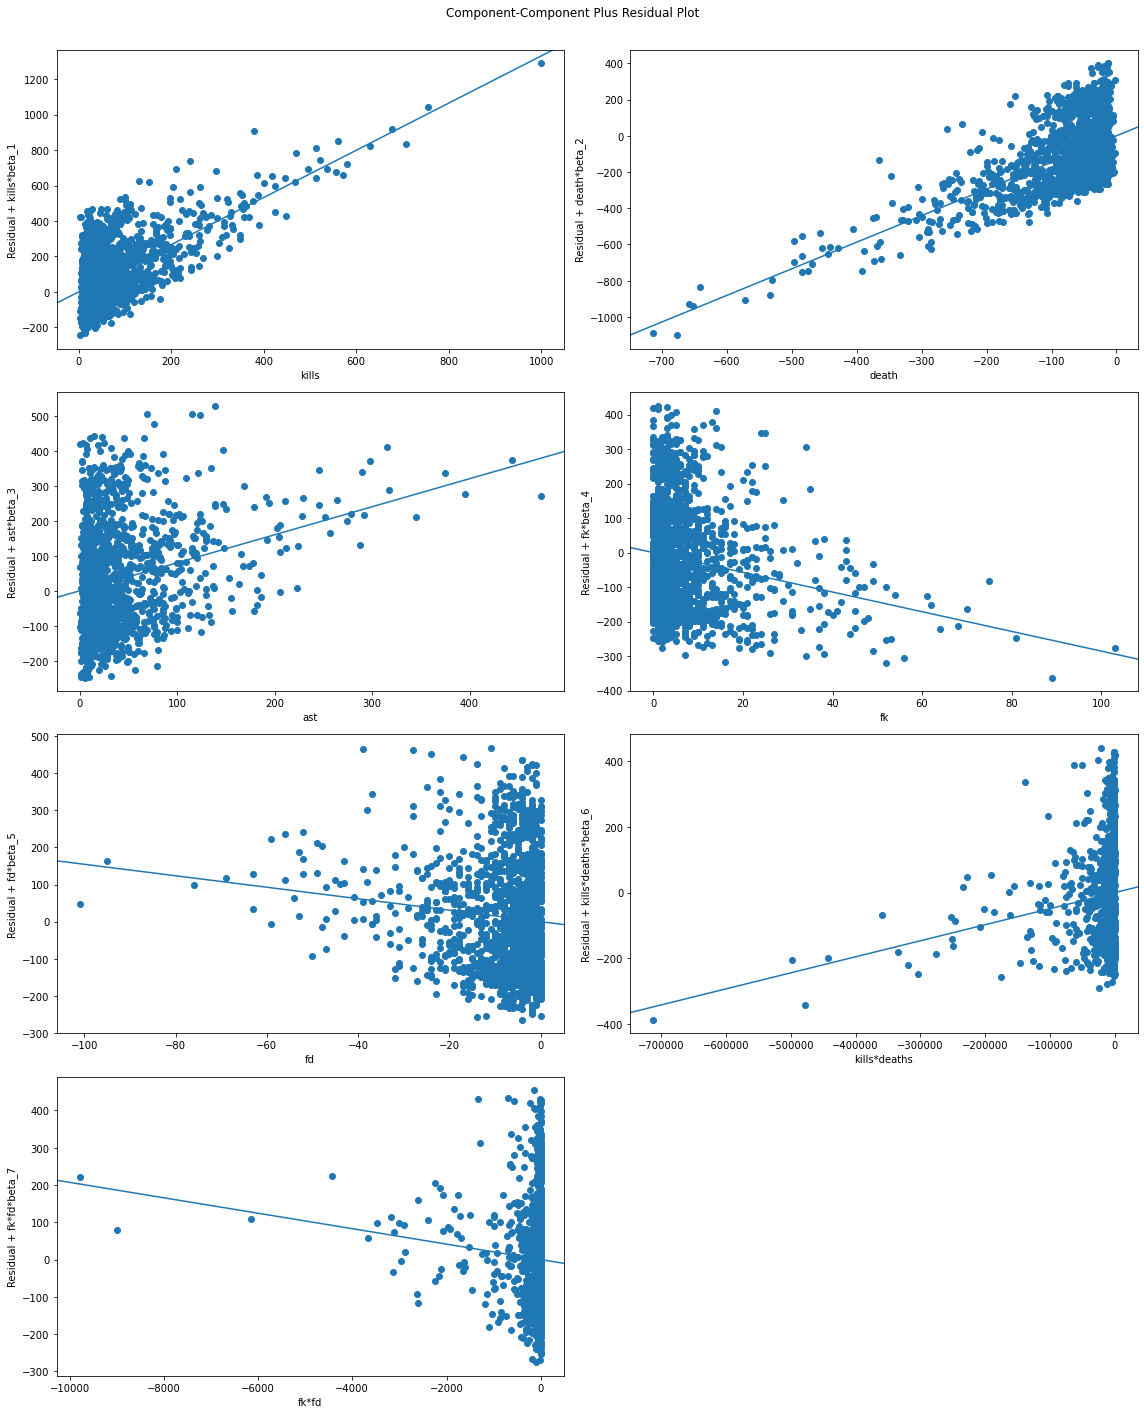

In [38]:
fig = plt.figure(figsize=(16,20))
sm.graphics.plot_ccpr_grid(initiator_model,fig=fig)
plt.show()

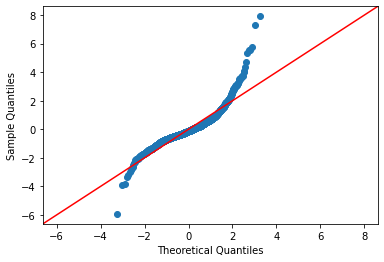

In [49]:
sm.qqplot(initiator_model.predict(), fit=True,line='45')
plt.show()

In [18]:
sentinel_model = sm.OLS(y_sentinel,x_sentinel).fit()
sentinel_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.325
Date:                Mon, 08 Aug 2022   Prob (F-statistic):           2.64e-07
Time:                        18:35:35   Log-Likelihood:                -7261.6
No. Observations:                1135   AIC:                         1.454e+04
Df Residuals:                    1127   BIC:                         1.458e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1568.0568      6.603    237.468      0.000    1555.101    1581.013
kills            1.2516      0.329      3.808      0.000       0.607       1.896
death            2.4043      0.383      6.275      0.000       1.653       3.156
ast              1.4820      0.419      3.535      0.000       0.659       2.305
fk               0.3915      1.194      0.328      0.743      -1.951       2.734
fd              -4.4498      1.349     -3.298      0.001      -7.097      -1.802
kills*deaths    -0.0004      0.000     -1.310      0.190      -0.001       0.000
fk*fd            0.0231      0.012      1.881      0.060      -0.001       0.047
==============================================================================
Omnibus:                       59.074   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.874
Skew:                           0.523   Prob(JB):                     9.97e-14
Kurtosis:                       2.586   Cond. No.                     1.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

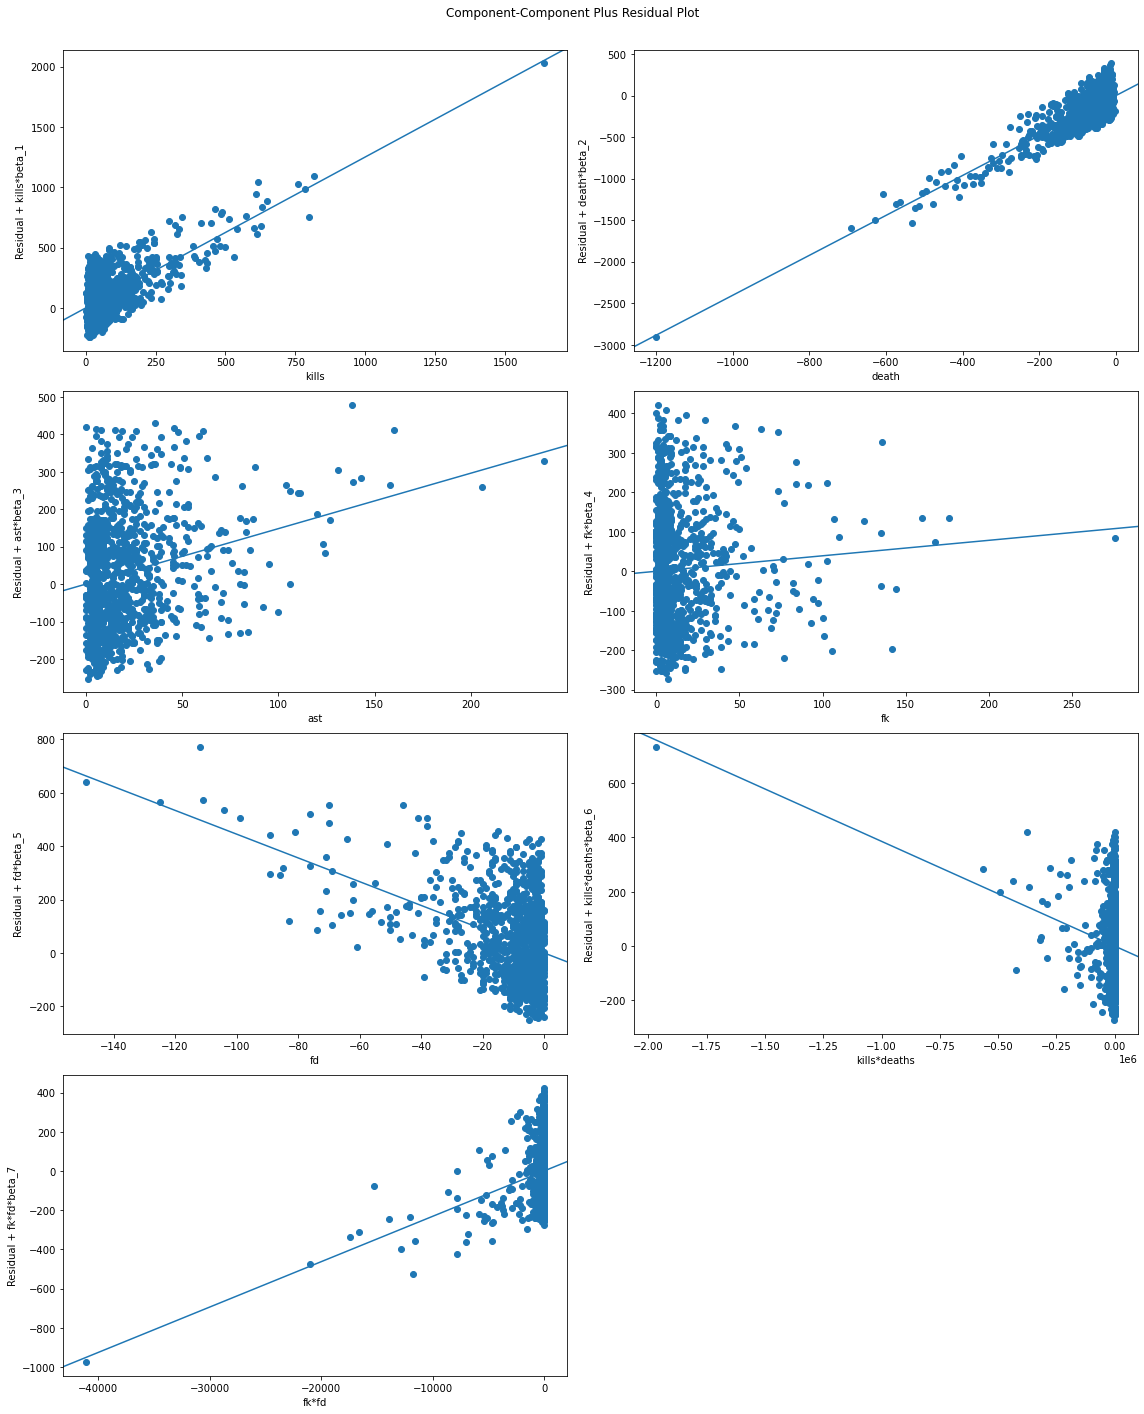

In [39]:
fig = plt.figure(figsize=(16,20))
sm.graphics.plot_ccpr_grid(sentinel_model,fig=fig)
plt.show()

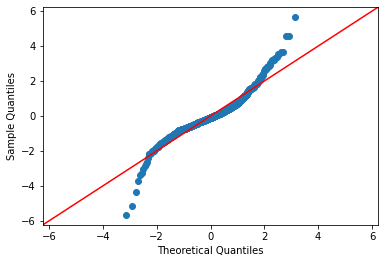

In [52]:
sm.qqplot(sentinel_model.predict(), fit=True,line='45')
plt.show()

### Log Transformation

#### Try a log transformation to help normalize rankings

In [145]:
#log transformation unsplit data
y_log = np.log(y_rank)
y_test_log = np.log(y_test_rank)
log_model = sm.OLS(y_log,x_rank).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     13.97
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           5.15e-29
Time:                        20:25:34   Log-Likelihood:                 4647.2
No. Observations:                4781   AIC:                            -9268.
Df Residuals:                    4768   BIC:                            -9184.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.8399      0.010    613.674      0.000       5.821       5.859
kill_death_ratio    -0.0020      0.006     -0.348      0.728      -0.013       0.009
kast                 0.0774      0.020      3.850      0.000       0.038       0.117
kills                0.0007      0.000      5.897      0.000       0.000       0.001
death                0.0010      0.000      8.003      0.000       0.001       0.001
ast                  0.0005      0.000      4.571      0.000       0.000       0.001
fk                  -0.0006      0.000     -1.541      0.123      -0.001       0.000
fd                  -0.0016      0.000     -4.297      0.000      -0.002      -0.001
is_controller        1.4564      0.004    415.369      0.000       1.450       1.463
is_duelist           1.4578      0.004    377.122      0.000       1.450       1.465
is_initiator         1.4622      0.003    428.176      0.000       1.456       1.469
is_sentinel          1.4634      0.003    433.111      0.000       1.457       1.470
kills*deaths      5.268e-08   9.51e-08      0.554      0.579   -1.34e-07    2.39e-07
fk*fd             8.693e-08   3.66e-06      0.024      0.981   -7.08e-06    7.26e-06
==============================================================================
Omnibus:                      252.839   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.149
Skew:                           0.459   Prob(JB):                     9.51e-49
Kurtosis:                       2.483   Cond. No.                     4.73e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.58e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

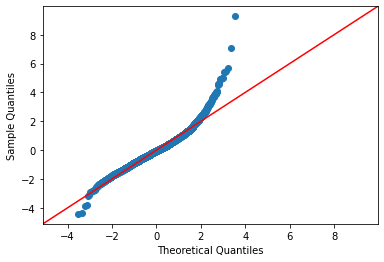

In [128]:
sm.qqplot(log_model.predict(), fit=True,line='45')
plt.show()

#### Duelist Log Model

In [146]:
#log transformation
duelist_log_transformation = np.log(y_duelist)
test_duelist_log = np.log(y_test_duelist)
log_duelist_model = sm.OLS(duelist_log_transformation,x_duelist).fit()
log_duelist_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.519
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           3.17e-06
Time:                        20:25:39   Log-Likelihood:                 838.46
No. Observations:                 862   AIC:                            -1661.
Df Residuals:                     854   BIC:                            -1623.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3519      0.005   1368.767      0.000       7.341       7.362
kills            0.0007      0.000      2.807      0.005       0.000       0.001
death            0.0016      0.000      5.423      0.000       0.001       0.002
ast              0.0007      0.000      1.639      0.102      -0.000       0.002
fk               0.0006      0.001      0.763      0.446      -0.001       0.002
fd              -0.0023      0.001     -2.983      0.003      -0.004      -0.001
kills*deaths -2.815e-07   4.44e-07     -0.634      0.526   -1.15e-06     5.9e-07
fk*fd         5.918e-06   9.03e-06      0.656      0.512   -1.18e-05    2.36e-05
==============================================================================
Omnibus:                       46.639   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.646
Skew:                           0.427   Prob(JB):                     6.69e-09
Kurtosis:                       2.436   Cond. No.                     7.89e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

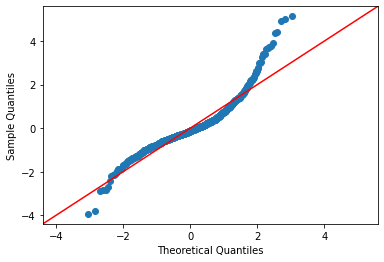

In [67]:
sm.qqplot(log_duelist_model.predict(), fit=True,line='45')
plt.show()

ValueError: num must be 1 <= num <= 5, not 6

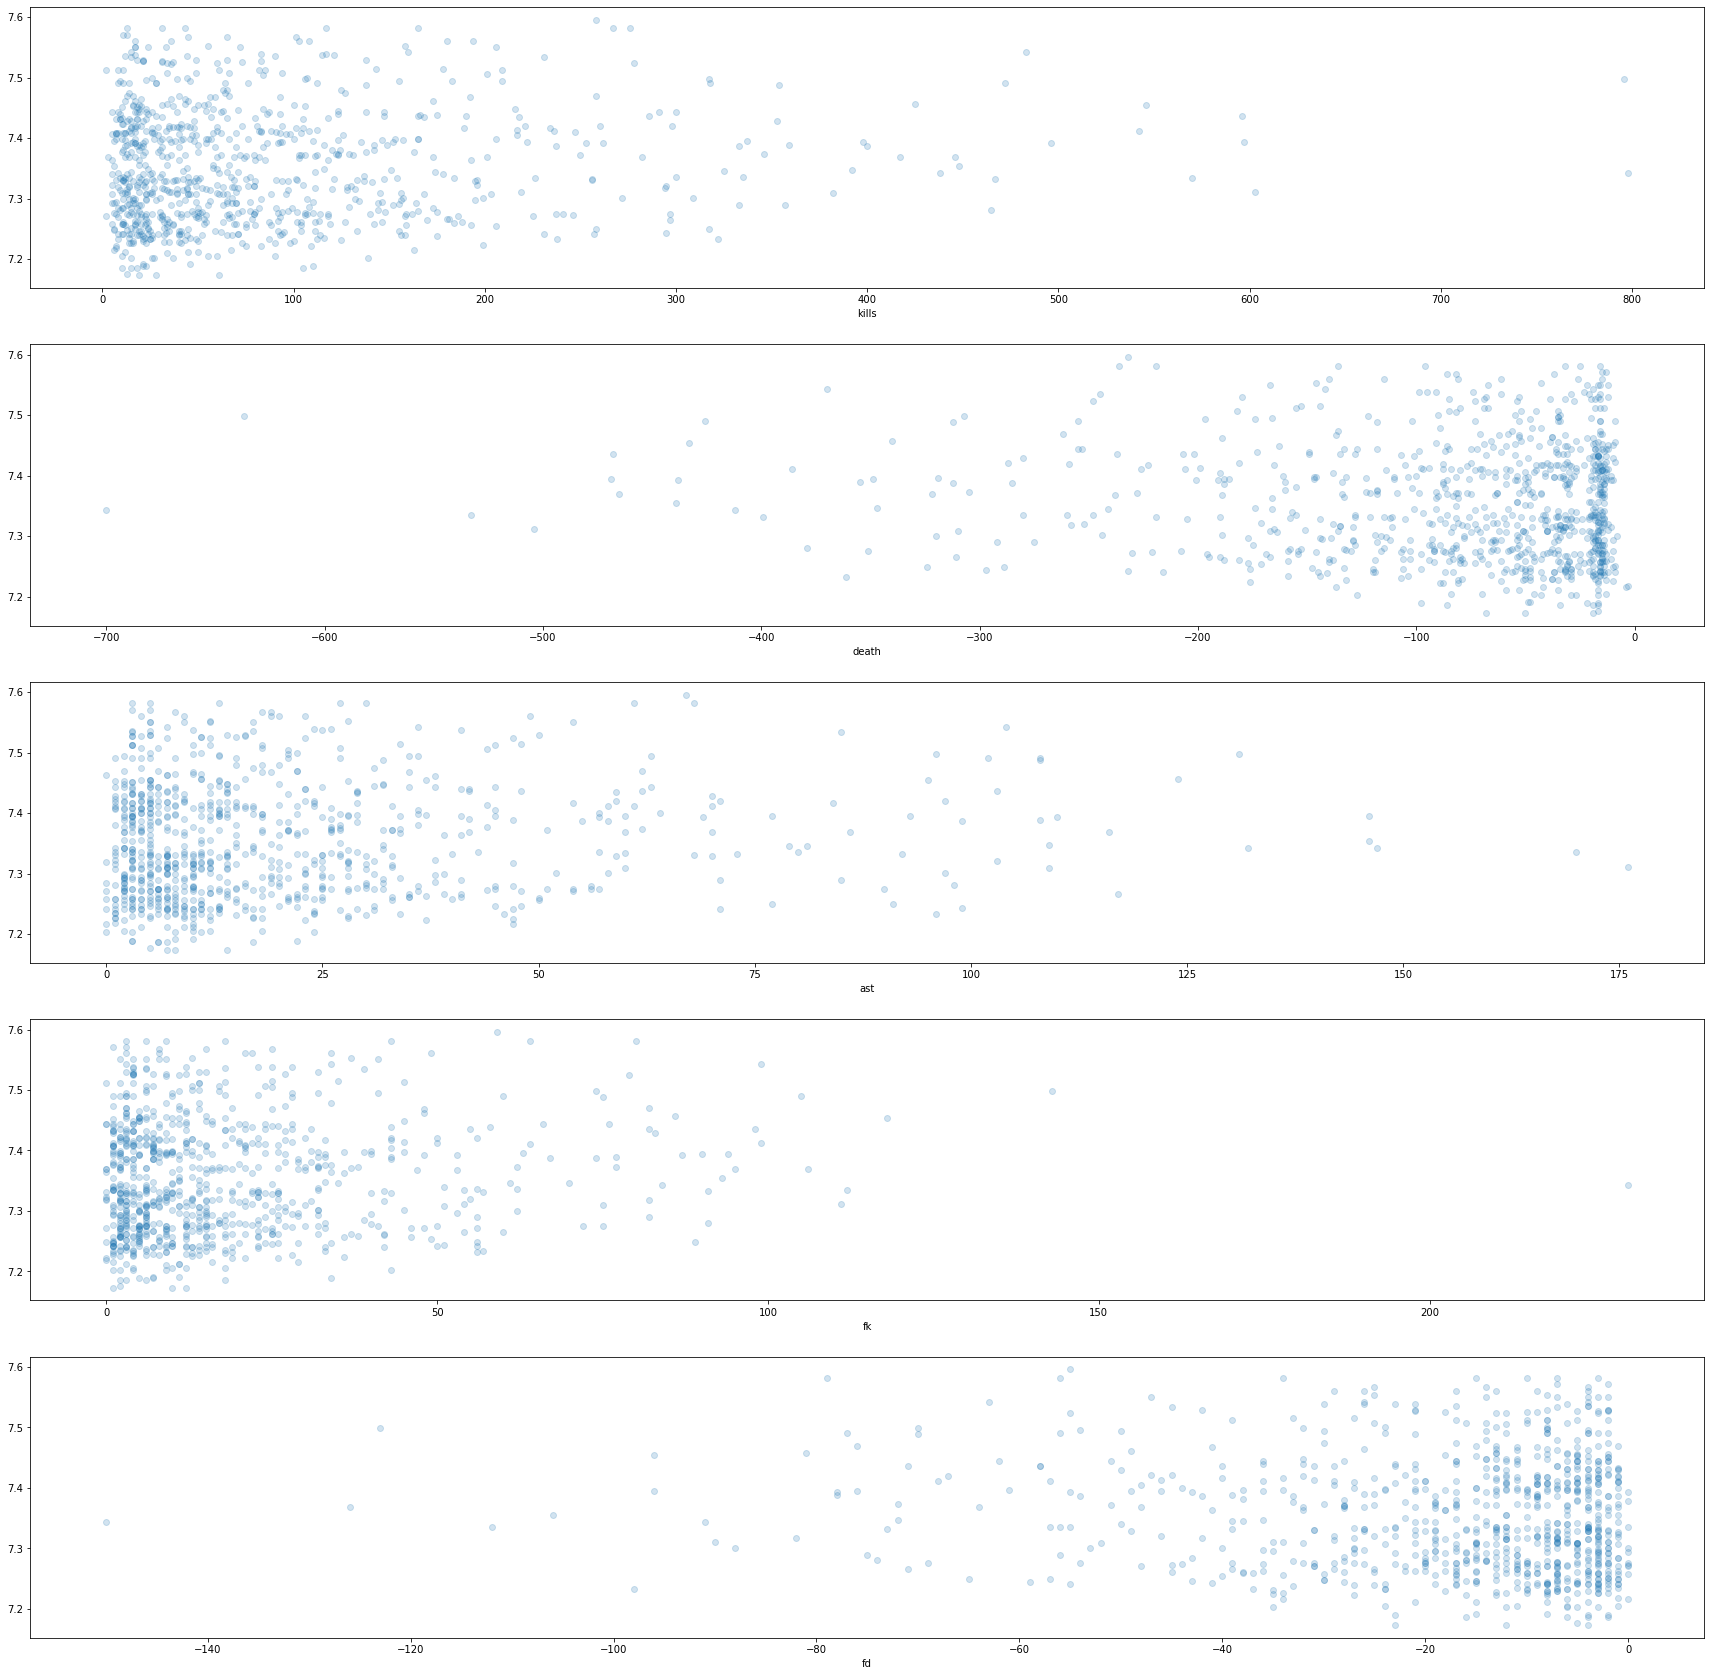

In [68]:
predicted_vs_actual_plot(x_duelist,duelist_log_transformation)

#### Controller Log Model

In [147]:
controller_log_transformation = np.log(y_controller)
test_controller_log = np.log(y_test_controller)
log_controller_model = sm.OLS(controller_log_transformation,x_controller).fit()
log_controller_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     4.714
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           3.14e-05
Time:                        20:25:42   Log-Likelihood:                 1101.0
No. Observations:                1139   AIC:                            -2186.
Df Residuals:                    1131   BIC:                            -2146.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3455      0.005   1542.606      0.000       7.336       7.355
kills            0.0008      0.000      3.389      0.001       0.000       0.001
death            0.0009      0.000      3.818      0.000       0.000       0.001
ast              0.0007      0.000      2.659      0.008       0.000       0.001
fk              -0.0015      0.001     -1.326      0.185      -0.004       0.001
fd              -0.0011      0.001     -0.978      0.328      -0.003       0.001
kills*deaths  3.307e-07   4.64e-07      0.713      0.476    -5.8e-07    1.24e-06
fk*fd        -5.948e-06   3.38e-05     -0.176      0.860   -7.23e-05    6.04e-05
==============================================================================
Omnibus:                       58.185   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.441
Skew:                           0.505   Prob(JB):                     3.36e-13
Kurtosis:                       2.566   Cond. No.                     5.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

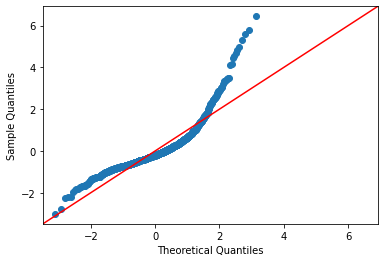

In [77]:
sm.qqplot(log_controller_model.predict(), fit=True,line='45')
plt.show()

ValueError: num must be 1 <= num <= 5, not 6

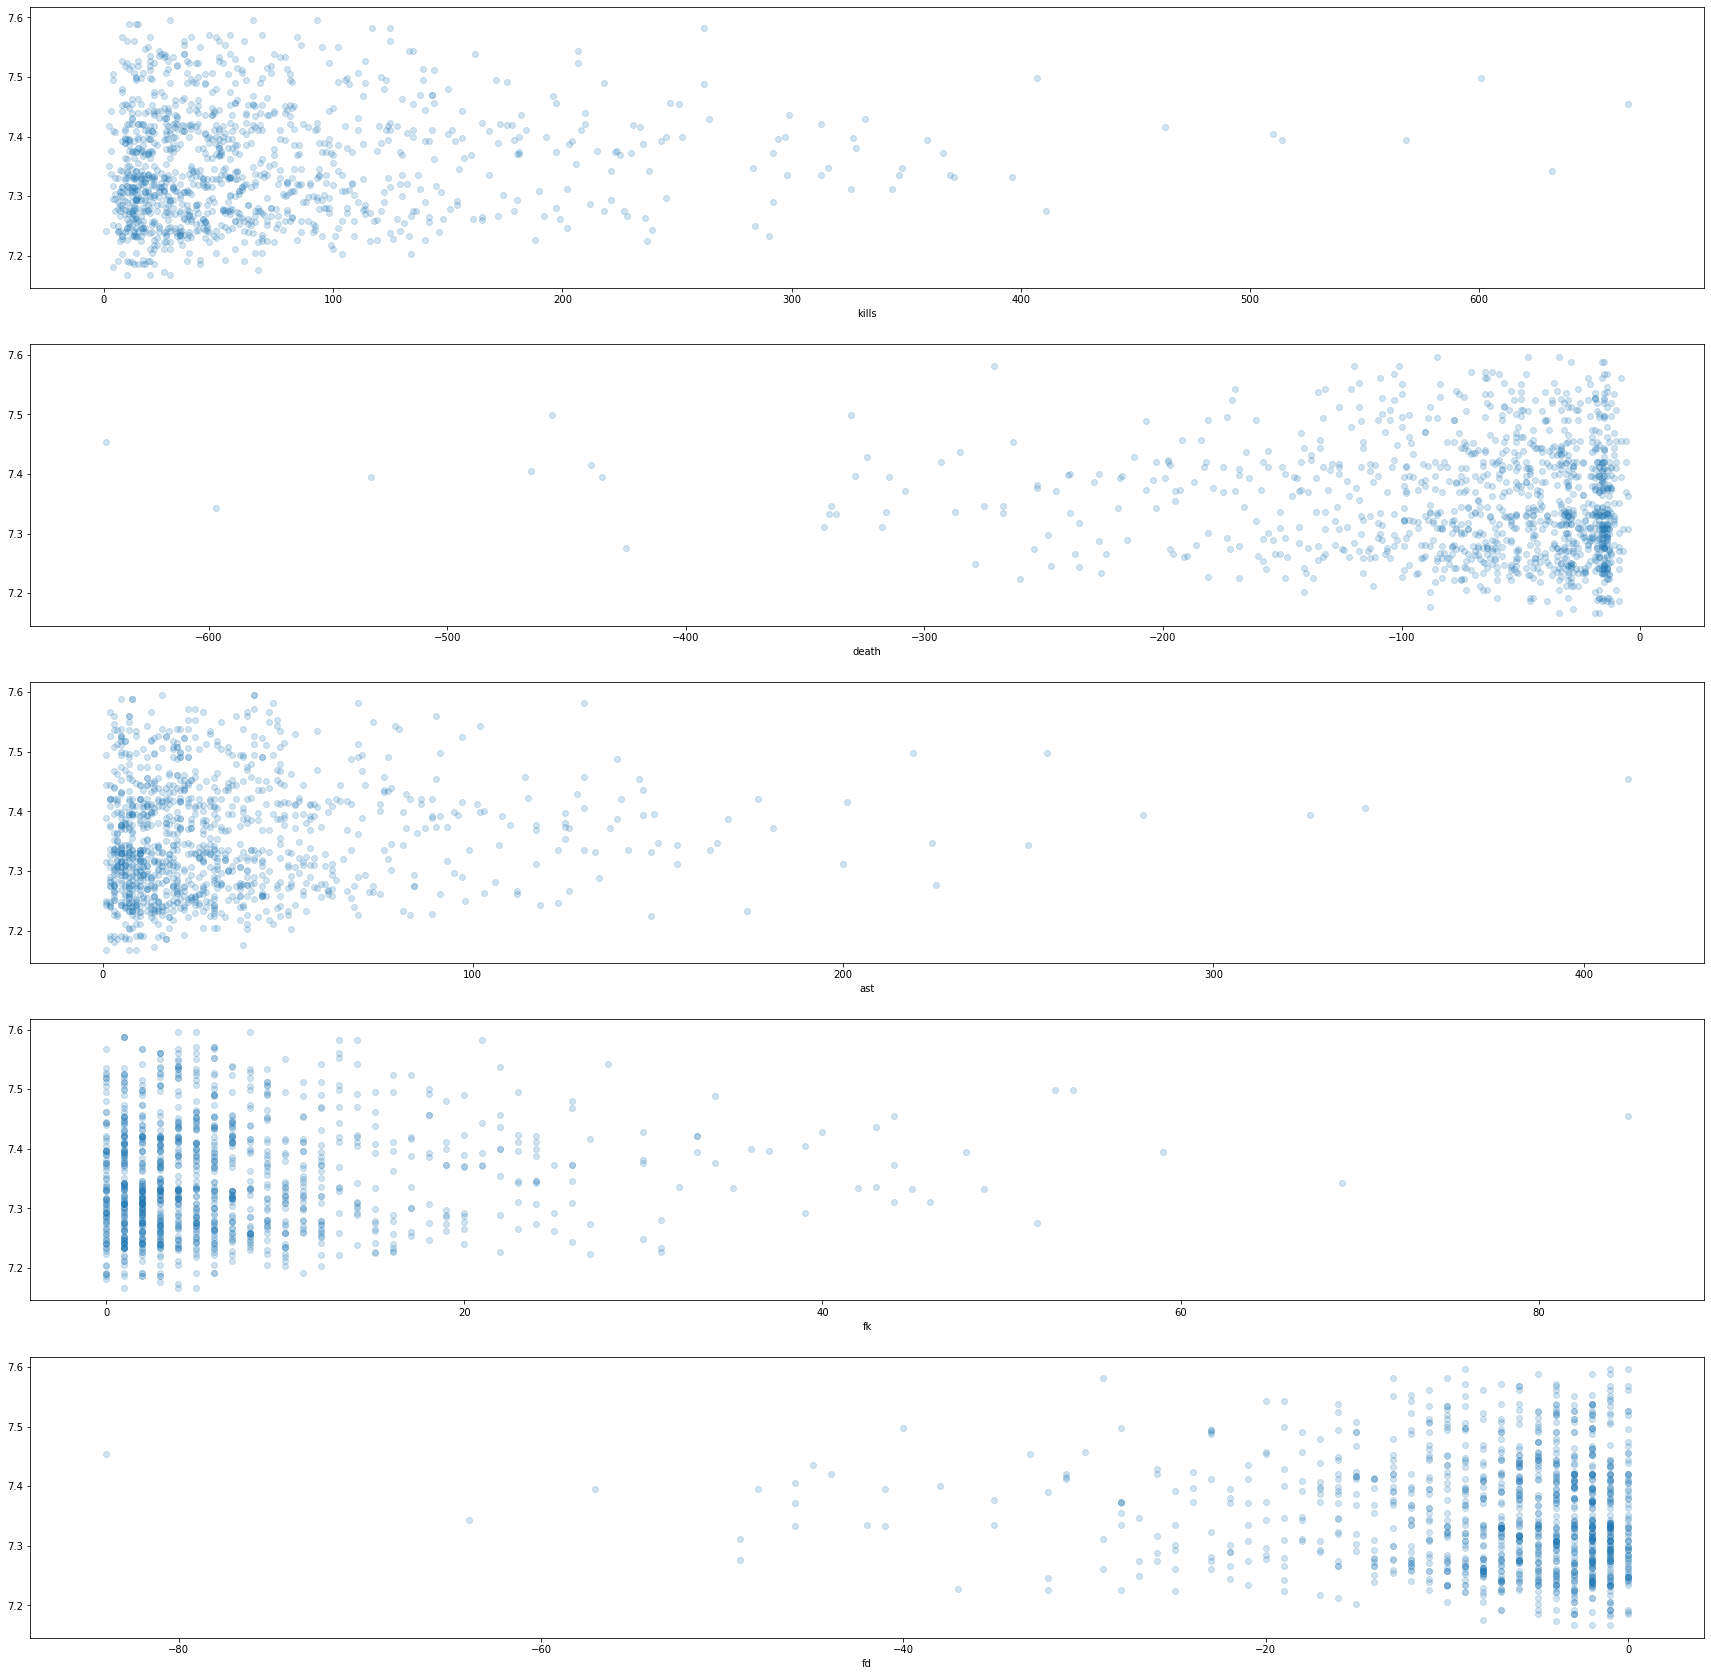

In [78]:
predicted_vs_actual_plot(x_controller,controller_log_transformation)

#### Initiator Log Model

In [148]:
initiator_log_transformation = np.log(y_initiator)
test_initiator_log = np.log(y_test_initiator)
log_initiator_model = sm.OLS(initiator_log_transformation,x_initiator).fit()
log_initiator_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6.860
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           4.66e-08
Time:                        20:25:45   Log-Likelihood:                 1595.8
No. Observations:                1645   AIC:                            -3176.
Df Residuals:                    1637   BIC:                            -3132.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3530      0.004   1996.550      0.000       7.346       7.360
kills            0.0008      0.000      4.938      0.000       0.001       0.001
death            0.0009      0.000      5.421      0.000       0.001       0.001
ast              0.0005      0.000      2.604      0.009       0.000       0.001
fk              -0.0018      0.001     -2.036      0.042      -0.004    -6.7e-05
fd              -0.0010      0.001     -1.300      0.194      -0.002       0.001
kills*deaths  3.051e-07   1.94e-07      1.572      0.116   -7.57e-08    6.86e-07
fk*fd        -1.337e-05   1.43e-05     -0.935      0.350   -4.14e-05    1.47e-05
==============================================================================
Omnibus:                       93.440   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.041
Skew:                           0.500   Prob(JB):                     2.07e-19
Kurtosis:                       2.495   Cond. No.                     6.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

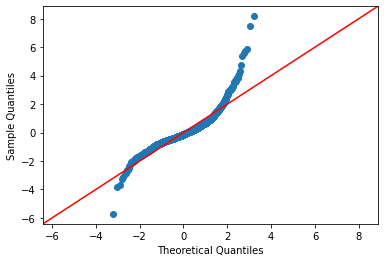

In [80]:
sm.qqplot(log_initiator_model.predict(), fit=True,line='45')
plt.show()

ValueError: num must be 1 <= num <= 5, not 6

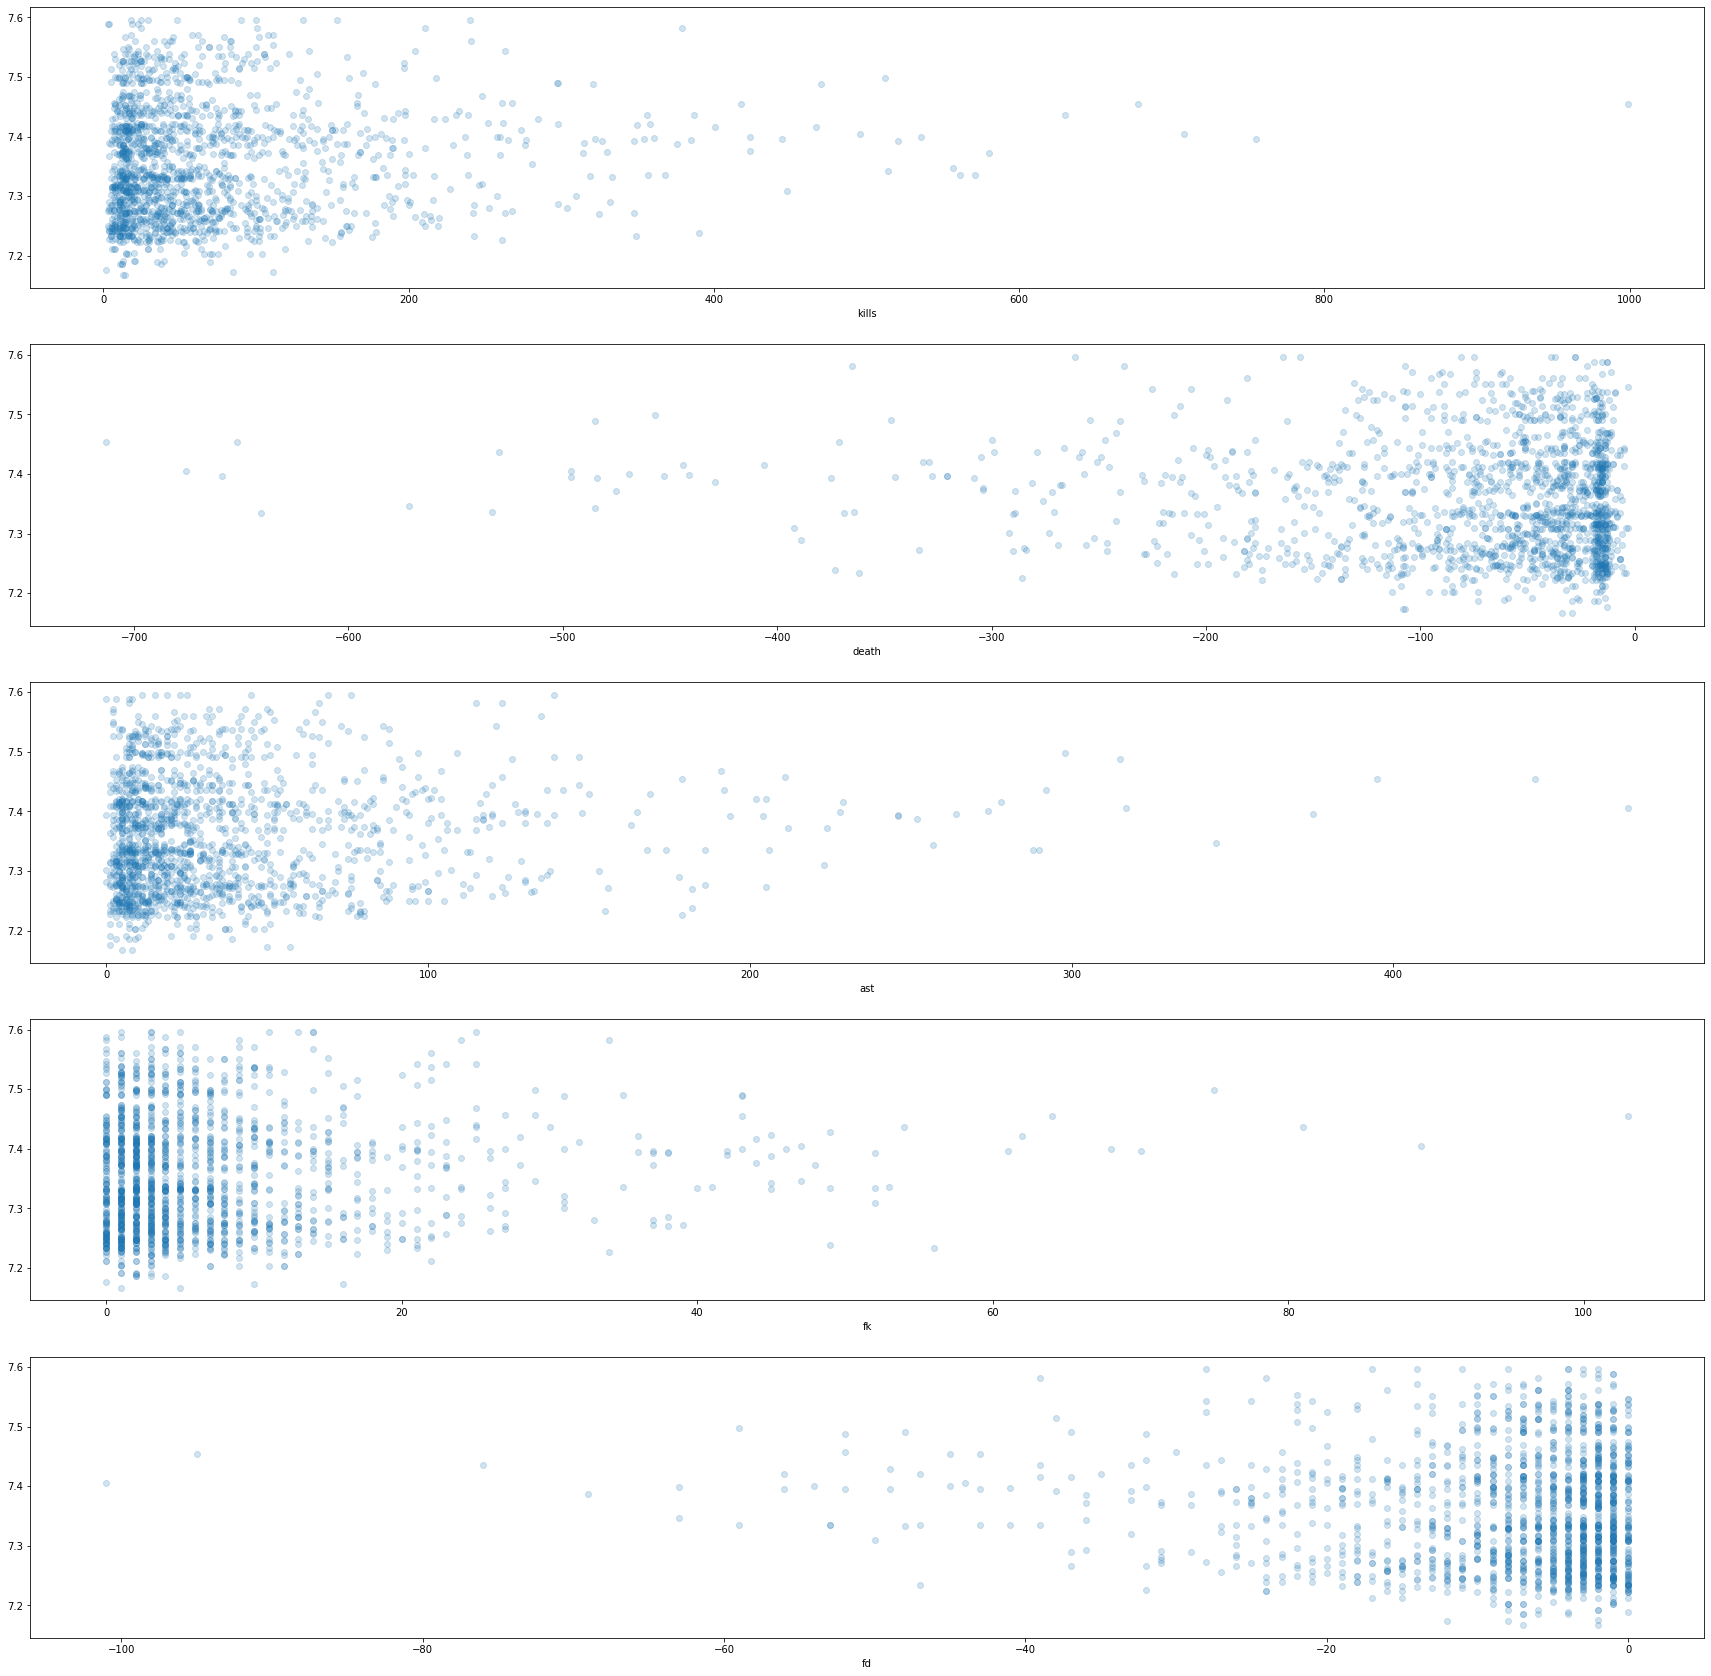

In [81]:
predicted_vs_actual_plot(x_initiator,initiator_log_transformation)

#### Sentinel Log Model

In [149]:
sentinel_log_transformation = np.log(y_sentinel)
test_sentinel_log = np.log(y_test_sentinel)
log_sentinel_model = sm.OLS(sentinel_log_transformation,x_sentinel).fit()
log_sentinel_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              team_rank   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.334
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           2.58e-07
Time:                        20:25:49   Log-Likelihood:                 1111.3
No. Observations:                1135   AIC:                            -2207.
Df Residuals:                    1127   BIC:                            -2166.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.3532      0.004   1780.419      0.000       7.345       7.361
kills            0.0008      0.000      3.851      0.000       0.000       0.001
death            0.0015      0.000      6.266      0.000       0.001       0.002
ast              0.0009      0.000      3.595      0.000       0.000       0.001
fk               0.0002      0.001      0.245      0.806      -0.001       0.002
fd              -0.0027      0.001     -3.250      0.001      -0.004      -0.001
kills*deaths -2.293e-07   1.84e-07     -1.245      0.213   -5.91e-07    1.32e-07
fk*fd          1.37e-05   7.69e-06      1.783      0.075   -1.38e-06    2.88e-05
==============================================================================
Omnibus:                       64.514   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.862
Skew:                           0.356   Prob(JB):                     4.93e-10
Kurtosis:                       2.367   Cond. No.                     1.17e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

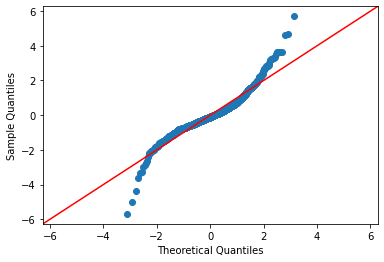

In [83]:
sm.qqplot(log_sentinel_model.predict(), fit=True,line='45')
plt.show()

ValueError: num must be 1 <= num <= 5, not 6

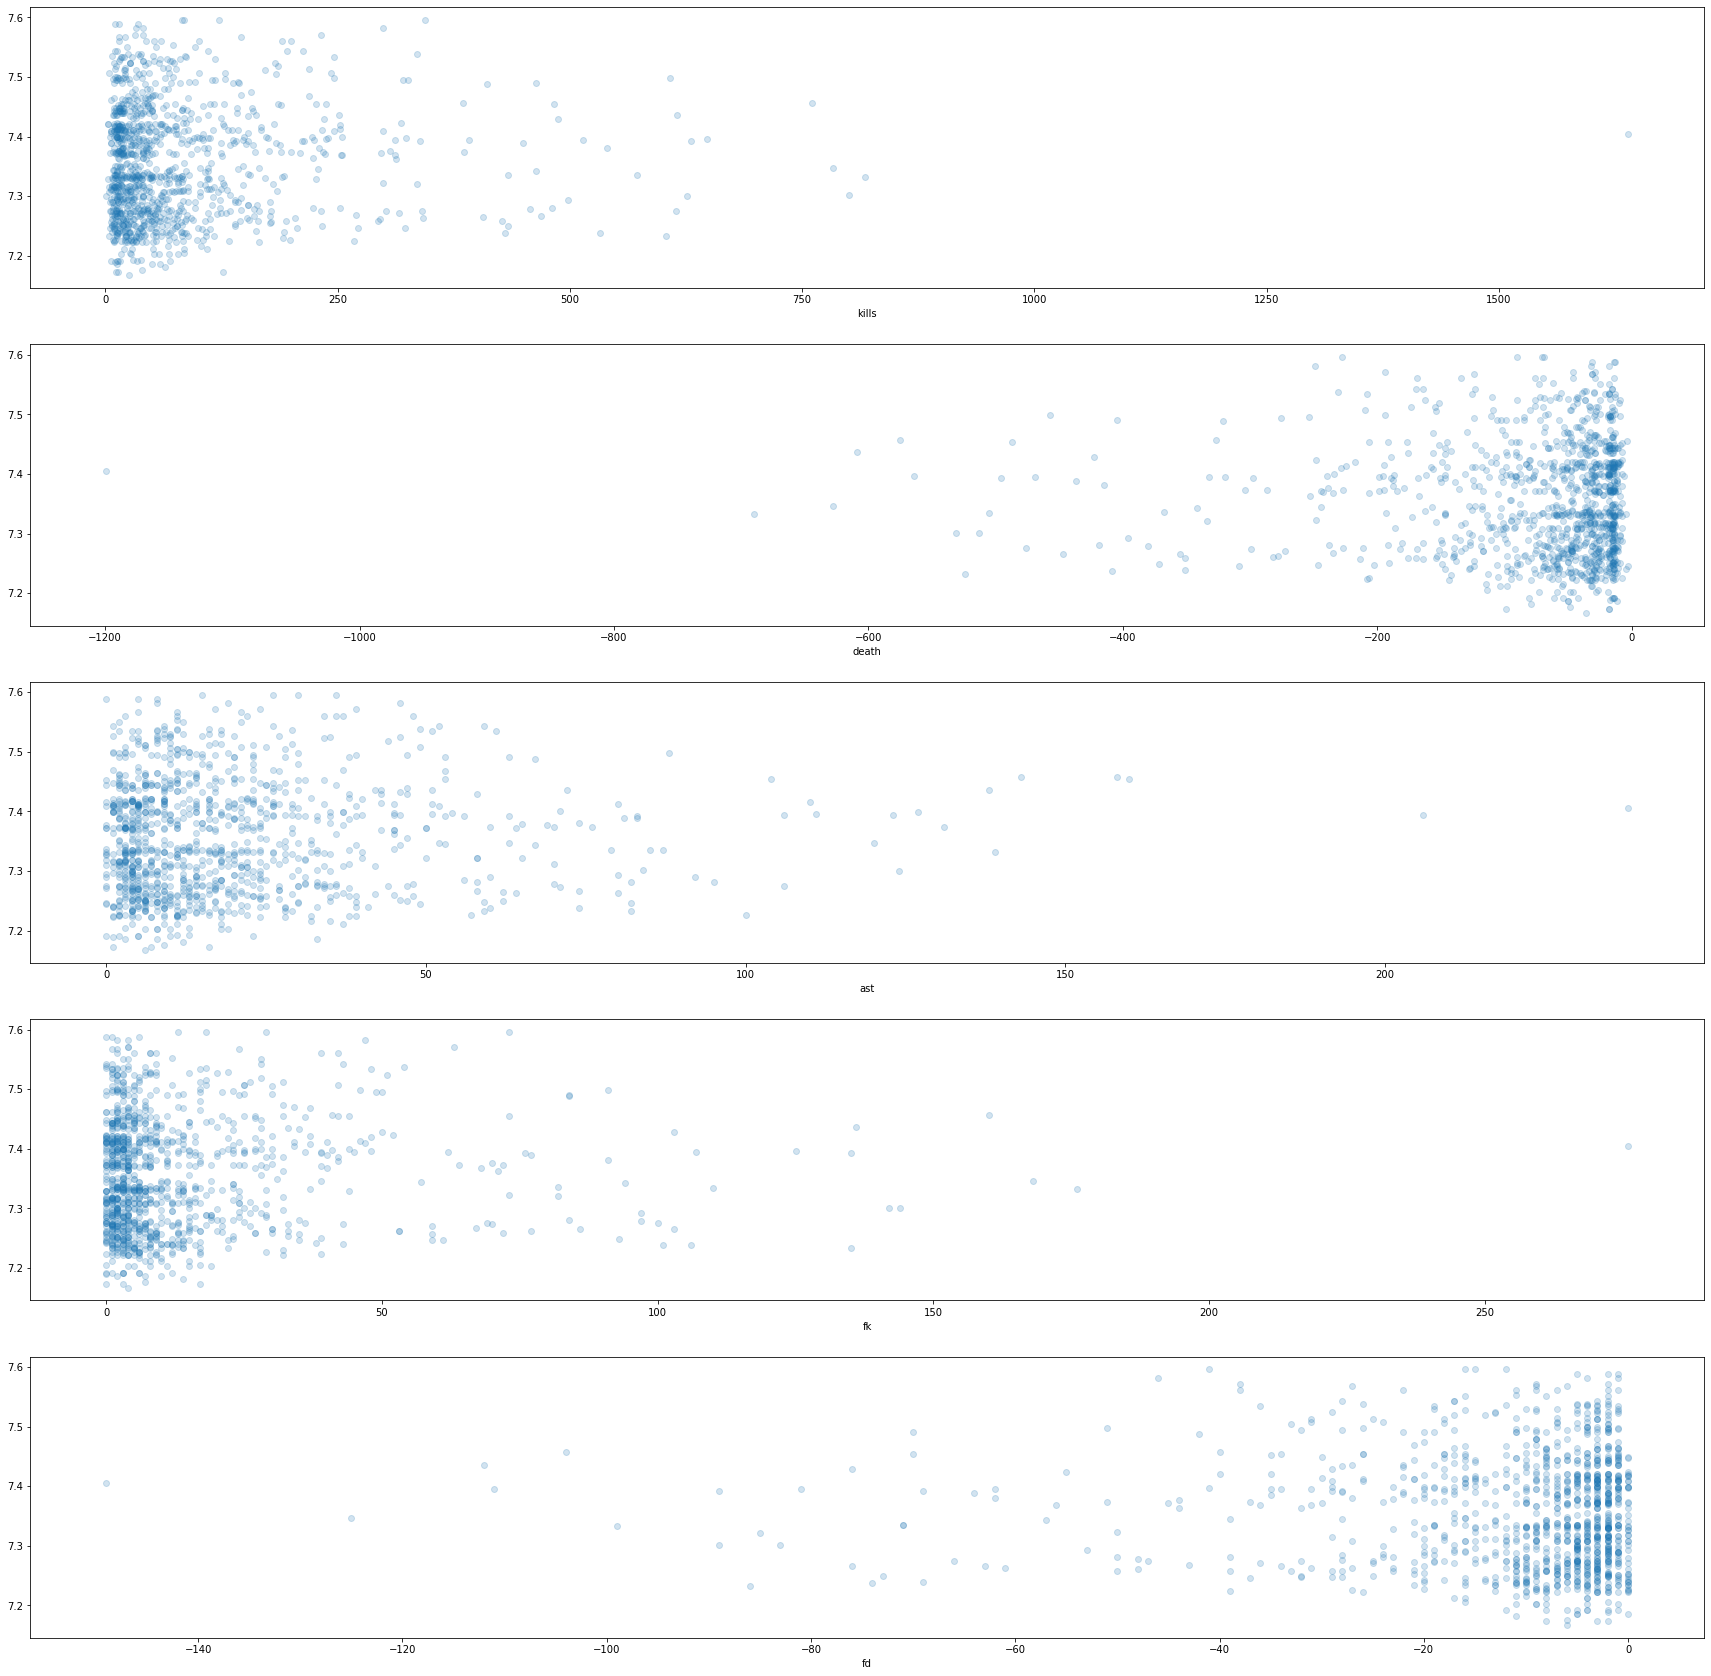

In [84]:
predicted_vs_actual_plot(x_sentinel,sentinel_log_transformation)

Log Transformations seem to have helped marginally for Controller and Initiator models. Investigate futher with Actual vs Predicted plots.

Text(0.5, 1.0, 'Duelist Fitted vs. Actual')

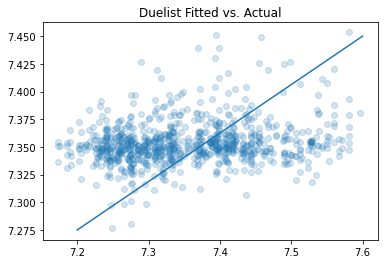

In [212]:
#Actual vs Fitted graph
log_y_train_pred = dueslist_lin_reg.predict(x_duelist)

plt.scatter(duelist_log_transformation, log_y_train_pred, alpha=0.2)
plt.plot([7.6,7.2],[7.450, 7.275])
plt.title("Duelist Fitted vs. Actual")

Text(0.5, 1.0, 'Controller Fitted vs. Actual')

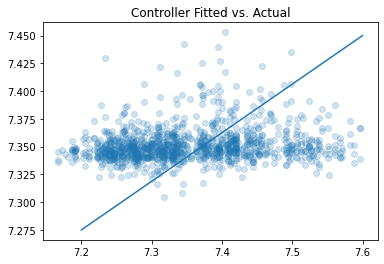

In [220]:
log_y_train_pred = controller_lin_reg.predict(x_controller)

plt.scatter(controller_log_transformation, log_y_train_pred, alpha=0.2)
plt.plot([7.6,7.2],[7.450, 7.275])
plt.title("Controller Fitted vs. Actual")

Text(0.5, 1.0, 'Initiator Fitted vs. Actual')

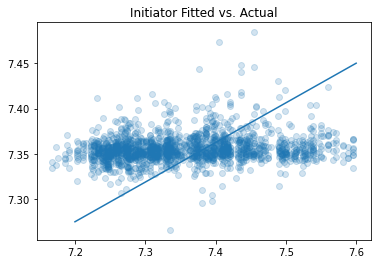

In [221]:
log_y_train_pred = initiator_lin_reg.predict(x_initiator)

plt.scatter(initiator_log_transformation, log_y_train_pred, alpha=0.2)
plt.plot([7.6,7.2],[7.450, 7.275])
plt.title("Initiator Fitted vs. Actual")

Text(0.5, 1.0, 'Sentinel Fitted vs. Actual')

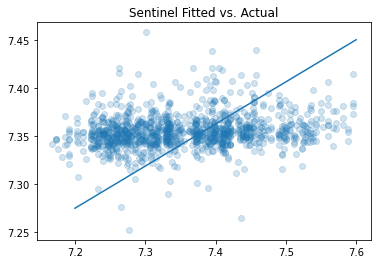

In [222]:
log_y_train_pred = sentinel_lin_reg.predict(x_sentinel)

plt.scatter(sentinel_log_transformation, log_y_train_pred, alpha=0.2)
plt.plot([7.6,7.2],[7.450, 7.275])
plt.title("Sentinel Fitted vs. Actual")

Ideally we would see the data points symetrically distributed along the regressed diagonal line. The found suggestion for this situation seems to be a Box-Cox Transformation. Lets give it a try.

Text(0.5, 1.0, 'Residuals vs. Predictions')

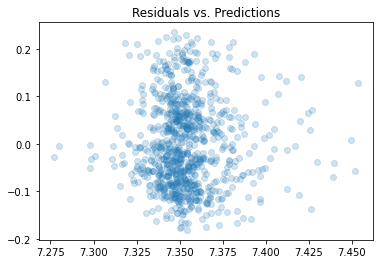

In [178]:
lin_reg_residuals = duelist_log_transformation - log_y_train_pred

plt.scatter(log_y_train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

### Polnomial Model

In [20]:
poly_model = PolynomialFeatures()

m_poly = LinearRegression()
m_poly.fit(poly_model.fit_transform(x_rank),y_rank)
m_poly_train_pred = m_poly.predict(poly_model.transform(x_rank))
print((r2_score(y_rank,m_poly_train_pred)))

NameError: name 'x_rank' is not defined

#### Duelist Polynomial Model

In [21]:
poly_duelist = PolynomialFeatures()

lm_poly = LinearRegression()
lm_poly.fit(poly_duelist.fit_transform(x_duelist),y_duelist)
poly_train_pred = lm_poly.predict(poly_duelist.transform(x_duelist))
print((r2_score(y_duelist,poly_train_pred)))

0.04782441733215914


Text(0.5, 1.0, 'Residuals vs. Predictions')

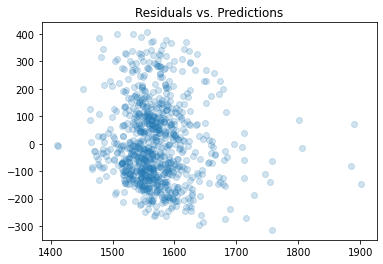

In [22]:
lin_reg_residuals = y_duelist - poly_train_pred

plt.scatter(poly_train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

#### Controller Polynomial Model

In [23]:
poly_controller = PolynomialFeatures()

cont_lm_poly = LinearRegression()
cont_lm_poly.fit(poly_controller.fit_transform(x_controller),y_controller)
cont_poly_train_pred = cont_lm_poly.predict(poly_controller.transform(x_controller))
print((r2_score(y_controller,cont_poly_train_pred)))

0.04079388463809497


Text(0.5, 1.0, 'Residuals vs. Predictions')

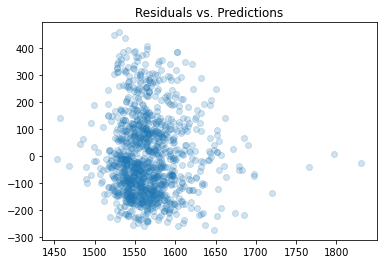

In [24]:
lin_reg_residuals = y_controller - cont_poly_train_pred

plt.scatter(cont_poly_train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

#### Initiator Polynomial Model

In [25]:
poly_initiator = PolynomialFeatures()

int_lm_poly = LinearRegression()
int_lm_poly.fit(poly_initiator.fit_transform(x_initiator),y_initiator)
int_poly_train_pred = int_lm_poly.predict(poly_initiator.transform(x_initiator))
print((r2_score(y_initiator,int_poly_train_pred)))

0.04182641393901876


Text(0.5, 1.0, 'Residuals vs. Predictions')

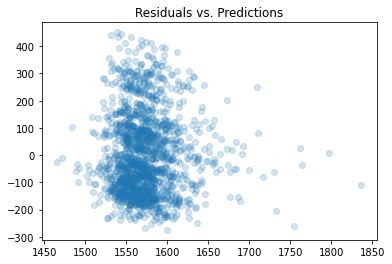

In [26]:
lin_reg_residuals = y_initiator - int_poly_train_pred

plt.scatter(int_poly_train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

#### Sentinel Polynomial Model

In [27]:
poly_sentinel = PolynomialFeatures()

sen_lm_poly = LinearRegression()
sen_lm_poly.fit(poly_sentinel.fit_transform(x_sentinel),y_sentinel)
sen_train_pred = sen_lm_poly.predict(poly_sentinel.transform(x_sentinel))
print((r2_score(y_sentinel,sen_train_pred)))

0.0742510786563465


Text(0.5, 1.0, 'Residuals vs. Predictions')

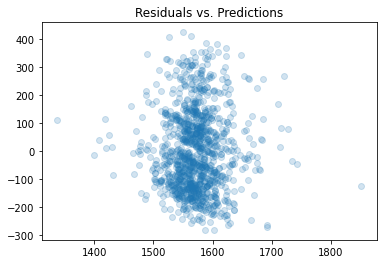

In [28]:
lin_reg_residuals = y_sentinel - sen_train_pred

plt.scatter(sen_train_pred, lin_reg_residuals, alpha=0.2)
plt.title("Residuals vs. Predictions")

## Evaluation

#### R2

Looking at a naive R2 evaluation it looks like by far our best performing model is the Polynomial Model.

As a recap our current R2 scores are as such:

| Model Name | R2 Score |
|:----------:|:----------:|
|unfiltered initial model| 0.033|
|----------|----------|
|filtered by rank|0.033|
|----------|----------|
|dueliest only|0.043|
|controller only|0.027|
|initiator only|0.027|
|sentinel only|0.038|
|----------|----------|
|log y| 0.034|
|log duelist|0.043|
|log controller|0.028|
|log initiator|0.028|
|log sentinel|0.038|
|----------|----------|
|poly y|0.048|
|poly duelist|0.047|
|poly controller|0.040|
|poly initiator|0.041|
|poly sentinel|0.074|

#### MAE

Data has had pretty large variance. Evaluation by MAE

In [102]:
unfiltered = mean_absolute_error(y_unfiltered,unfiltered_model.predict())
print("Unfiltered: ", mean_absolute_error(y_unfiltered,unfiltered_model.predict()))

Unfiltered:  154.35429491239947


In [103]:
rank_filter = mean_absolute_error(y_rank,rank_model.predict())
print("Rank Filter: ", mean_absolute_error(y_rank,rank_model.predict()))

Rank Filter:  121.13634419978482


In [104]:
duelist = mean_absolute_error(y_duelist,duelist_model.predict())
print("Duelist Filter: ", mean_absolute_error(y_duelist,duelist_model.predict()))

Duelist Filter:  121.07141629096253


In [105]:
controller = mean_absolute_error(y_controller,controller_model.predict())
print("Controller Filter: ", mean_absolute_error(y_controller,controller_model.predict()))

Controller Filter:  121.16686409484787


In [107]:
initiator = mean_absolute_error(y_initiator,initiator_model.predict())
print("Initiator Filter: ", mean_absolute_error(y_initiator,initiator_model.predict()))

Initiator Filter:  121.40336442439563


In [108]:
sentinel = mean_absolute_error(y_sentinel,sentinel_model.predict())
print("Sentinel Filter: ", mean_absolute_error(y_sentinel,sentinel_model.predict()))

Sentinel Filter:  120.65943967360539


In [130]:
logged = mean_absolute_error(y_log,log_model.predict())
print("Log: ", mean_absolute_error(y_log,log_model.predict()))

Log:  0.07627849549394618


In [131]:
duelist_logged = mean_absolute_error(duelist_log_transformation,log_duelist_model.predict())
print("Duelist Log: ", mean_absolute_error(duelist_log_transformation,log_duelist_model.predict()))

Duelist Log:  0.0763157026301463


In [132]:
controller_logged = mean_absolute_error(controller_log_transformation,log_controller_model.predict())
print("Controller Log: ", mean_absolute_error(controller_log_transformation,log_controller_model.predict()))

Controller Log:  0.07628014464120217


In [133]:
initiator_logged = mean_absolute_error(initiator_log_transformation,log_initiator_model.predict())
print("Initiator Log: ", mean_absolute_error(initiator_log_transformation,log_initiator_model.predict()))

Initiator Log:  0.07628886286762586


In [134]:
sentinel_logged = mean_absolute_error(sentinel_log_transformation,log_sentinel_model.predict())
print("Sentinel Log: ", mean_absolute_error(sentinel_log_transformation,log_sentinel_model.predict()))

Sentinel Log:  0.07615741827088633


In [120]:
polyd = mean_absolute_error(y_rank,m_poly_train_pred)
print("Poly: ", mean_absolute_error(y_rank,m_poly_train_pred))

Poly:  119.57408888038066


In [52]:
duelist_polyd = mean_absolute_error(y_duelist,poly_train_pred)
print("Poly Duelist: ", mean_absolute_error(y_duelist,poly_train_pred))

Poly Duelist:  119.52186827933369


In [53]:
controller_polyd = mean_absolute_error(y_controller,cont_poly_train_pred)
print("Poly Controller: ", mean_absolute_error(y_controller,cont_poly_train_pred))

Poly Controller:  119.17959979463645


In [54]:
initiator_polyd = mean_absolute_error(y_initiator,int_poly_train_pred)
print("Poly Initiator: ", mean_absolute_error(y_initiator,int_poly_train_pred))

Poly Initiator:  120.19562275331714


In [56]:
sentinel_polyd = mean_absolute_error(y_sentinel,sen__train_pred)
print("Poly Sentinel: ", mean_absolute_error(y_sentinel,sen_train_pred))

NameError: name 'sen__train_pred' is not defined

| Model Name | R2 Score | MAE|
|:----------:|:----------:|:----------:|
|unfiltered initial model| 0.033|154.35|
|----------|----------|----------|
|filtered by rank|0.033|121.14|
|----------|----------|----------|
|dueliest only|0.043|121.07|
|controller only|0.027|121.17|
|initiator only|0.027|121.40|
|sentinel only|0.038|120.66|
|----------|----------|----------|
|log y| 0.034|0.076|
|log duelist|0.043|0.076|
|log controller|0.028|0.076|
|log initiator|0.028|0.076|
|log sentinel|0.038|0.076|
|----------|----------|----------|
|poly y|0.048|119.57|
|poly duelist|0.047|119.52|
|poly controller|0.040|119.18|
|poly initiator|0.041|120.20|
|poly sentinel|0.074|117.59|

*of note: Log MAE values are a percentage instead of a difference of ELO Rating

#### Run Test Set

In [152]:
pred = unfiltered_model.predict(x_test_unfiltered)
print("Unfiltered R2: ", r2_score(y_test_unfiltered,pred))
print("Unfiltered MAE: ", mean_absolute_error(y_test_unfiltered,pred))

Unfiltered R2:  -0.00029540200554634133
Unfiltered MAE:  146.402491862047


In [153]:
pred = rank_model.predict(x_test_rank)
print("Rank Filter R2: ", r2_score(y_test_rank,pred))
print("Rank Filter MAE: ", mean_absolute_error(y_test_rank,pred))

Rank Filter R2:  0.015518498887841736
Rank Filter MAE:  118.20749708352021


In [154]:
pred = duelist_model.predict(x_test_duelist)
print("Duelist Filter R2: ", r2_score(y_test_duelist,pred))
print("Duelist Filter MAE: ", mean_absolute_error(y_test_duelist,pred))

Duelist Filter R2:  -0.005939099745561727
Duelist Filter MAE:  122.77606307742522


In [155]:
pred = controller_model.predict(x_test_controller)
print("Controller Filter R2: ", r2_score(y_test_controller,pred))
print("Controller Filter MAE: ", mean_absolute_error(y_test_controller,pred))

Controller Filter R2:  0.04341913163258804
Controller Filter MAE:  119.21199399212644


In [156]:
pred = initiator_model.predict(x_test_initiator)
print("Initiator Filter R2: ", r2_score(y_test_initiator,pred))
print("Initiator Filter MAE: ", mean_absolute_error(y_test_initiator,pred))

Initiator Filter R2:  0.023671952008112007
Initiator Filter MAE:  115.75979229245236


In [157]:
pred = sentinel_model.predict(x_test_sentinel)
print("Sentinel Filter R2: ", r2_score(y_test_sentinel,pred))
print("Sentinel Filter MAE: ", mean_absolute_error(y_test_sentinel,pred))

Sentinel Filter R2:  -0.05726955213431428
Sentinel Filter MAE:  120.52450079968848


In [158]:
pred = log_model.predict(x_test_rank)
print("Log R2: ", r2_score(y_test_log,pred))
print("Log MAE: ", mean_absolute_error(y_test_log,pred))

Log R2:  0.017197902807526866
Log MAE:  0.07479416383969019


In [159]:
pred = log_duelist_model.predict(x_test_duelist)
print("Duelist Log R2: ", r2_score(test_duelist_log,pred))
print("Duelist Log MAE: ", mean_absolute_error(test_duelist_log,pred))

Duelist Log R2:  -0.004794491233792275
Duelist Log MAE:  0.07768194778616976


In [160]:
pred = log_controller_model.predict(x_test_controller)
print("Controller Log R2: ", r2_score(test_controller_log,pred))
print("Controller Log MAE: ", mean_absolute_error(test_controller_log,pred))

Controller Log R2:  0.04511331878384961
Controller Log MAE:  0.07532978948760236


In [161]:
pred = log_initiator_model.predict(x_test_initiator)
print("Initiator Log R2: ", r2_score(test_initiator_log,pred))
print("Initiator Log MAE: ", mean_absolute_error(test_initiator_log,pred))

Initiator Log R2:  0.025140137467352774
Initiator Log MAE:  0.07328086616593756


In [162]:
pred = log_sentinel_model.predict(x_test_sentinel)
print("Sentinel Log R2: ", r2_score(test_sentinel_log,pred))
print("Sentinel Log MAE: ", mean_absolute_error(test_sentinel_log,pred))

Sentinel Log R2:  -0.05382279615999308
Sentinel Log MAE:  0.07619855429840759


In [170]:
poly_model = PolynomialFeatures()

m_poly = LinearRegression()
m_poly.fit(poly_model.fit_transform(x_test_rank),y_test_rank)
m_poly_train_pred = m_poly.predict(poly_model.transform(x_test_rank))
print("Poly R2: ", r2_score(y_test_rank,m_poly_train_pred))
print("Poly MAE: ", mean_absolute_error(y_test_rank,m_poly_train_pred))

Poly R2:  0.09224555213897112
Poly MAE:  111.88924612309607


In [29]:
poly_duelist = PolynomialFeatures()

lm_poly = LinearRegression()
lm_poly.fit(poly_duelist.fit_transform(x_test_duelist),y_test_duelist)
poly_train_pred = lm_poly.predict(poly_duelist.transform(x_test_duelist))
print("Poly Duelist R2: ", r2_score(y_test_duelist,poly_train_pred))
print("Poly Duelist MAE: ", mean_absolute_error(y_test_duelist,poly_train_pred))

Poly Duelist R2:  0.13985153187117272
Poly Duelist MAE:  111.71929793390245


In [30]:
poly_controller = PolynomialFeatures()

cont_lm_poly = LinearRegression()
cont_lm_poly.fit(poly_controller.fit_transform(x_test_controller),y_test_controller)
cont_poly_train_pred = cont_lm_poly.predict(poly_controller.transform(x_test_controller))
print("Poly Controller R2: ", r2_score(y_test_controller,cont_poly_train_pred))
print("Poly Controller MAE: ", mean_absolute_error(y_test_controller,cont_poly_train_pred))

Poly Controller R2:  0.12047896817764092
Poly Controller MAE:  110.43518030375766


In [31]:
poly_initiator = PolynomialFeatures()

int_lm_poly = LinearRegression()
int_lm_poly.fit(poly_initiator.fit_transform(x_test_initiator),y_test_initiator)
int_poly_train_pred = int_lm_poly.predict(poly_initiator.transform(x_test_initiator))
print("Poly Initiator R2: ", r2_score(y_test_initiator,int_poly_train_pred))
print("Poly Initiator MAE: ", mean_absolute_error(y_test_initiator,int_poly_train_pred))

Poly Initiator R2:  0.10425872280589898
Poly Initiator MAE:  108.90400645689056


In [32]:
poly_sentinel = PolynomialFeatures()

sen_lm_poly = LinearRegression()
sen_lm_poly.fit(poly_sentinel.fit_transform(x_test_sentinel),y_test_sentinel)
sen_train_pred = sen_lm_poly.predict(poly_sentinel.transform(x_test_sentinel))
print("Poly Sentinel R2: ", r2_score(y_test_sentinel,sen_train_pred))
print("Poly Sentinel MAE: ", mean_absolute_error(y_test_sentinel,sen_train_pred))

Poly Sentinel R2:  0.10949940200650399
Poly Sentinel MAE:  108.5705041300976


New table with test scores:

| Model Name | R2 Score | MAE|Test R2|Test MAE|
|:----------:|:----------:|:----------:|:----------:|:----------:|
|unfiltered initial model| 0.033|154.35|-0.0002 |146.40 |
|----------|----------|----------|----------|----------|
|filtered by rank|0.033|121.14|0.016 |118.21 |
|----------|----------|----------|----------|----------|
|dueliest only|0.043|121.07|-0.006|122.78 |
|controller only|0.027|121.17| 0.043| 119.21|
|initiator only|0.027|121.40|0.024 | 115.76|
|sentinel only|0.038|120.66|-0.057|120.52 |
|----------|----------|----------|----------|----------|
|log y| 0.034|0.076|0.017 | 0.075|
|log duelist|0.043|0.076|-0.005 |0.078 |
|log controller|0.028|0.076|0.045 |0.075 |
|log initiator|0.028|0.076|0.025 | 0.073|
|log sentinel|0.038|0.076| -0.054 |0.076 |
|----------|----------|----------|----------|----------|
|poly y|0.048|119.57|  0.092|111.89 |
|poly duelist|0.047|119.52|0.140|111.72|
|poly controller|0.040|119.18|0.120 |110.44 |
|poly initiator|0.041|120.20|0.104 | 108.90|
|poly sentinel|0.074|117.59|0.109 |108.57 |

*of note: Log MAE values are a percentage instead of a difference of ELO Rating

C:\Users\Angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


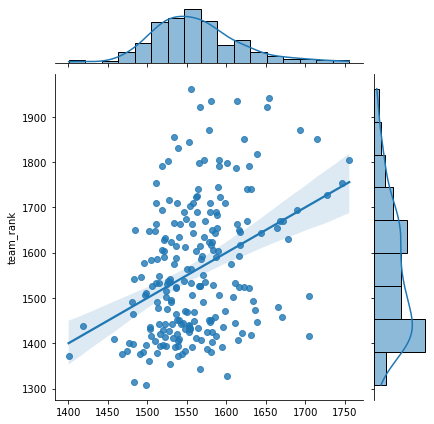

In [34]:
sns.jointplot(poly_train_pred, y_test_duelist, kind='reg')

C:\Users\Angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


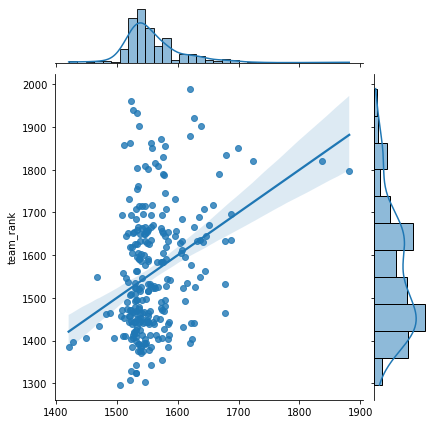

In [64]:
sns.jointplot(cont_poly_train_pred, y_test_controller, kind='reg')

C:\Users\Angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


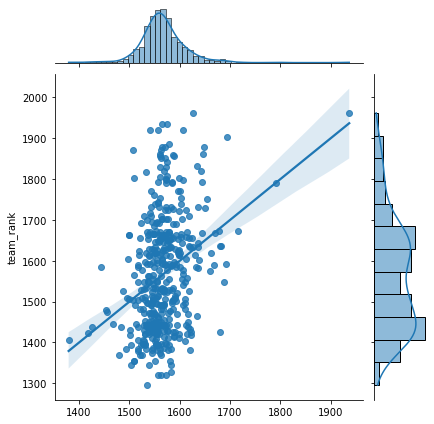

In [65]:
sns.jointplot(int_poly_train_pred, y_test_initiator, kind='reg')

C:\Users\Angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


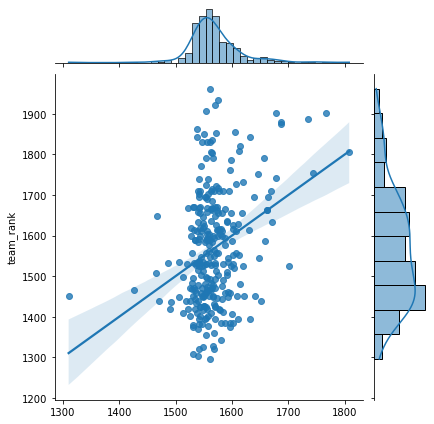

In [66]:
sns.jointplot(sen_train_pred, y_test_sentinel, kind='reg')